In [2]:
using PorousMaterials # Pkg.clone("https://github.com/SimonEnsemble/PorousMaterials.jl", "v0.1.1")
using CSV
using DataFrames
using TSne
using PyCall
@pyimport adjustText
using PyPlot
using DelimitedFiles
using LinearAlgebra
using Printf
using Random

┌ Info: Recompiling stale cache file /home/sturlusa/.julia/compiled/v1.0/PorousMaterials.ji for PorousMaterials [top-level]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/sturlusa/.julia/compiled/v1.0/Optim/R5uoh.ji for Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1184


Cage database CDB41 (41 cages) from [here](https://github.com/marcinmiklitz/CDB41). Cleaned of solvent. Thanks to Kim Jelfs and M. Miklitz for kindly providing the cages.

Reference:
> M. Miklitz, S. Jiang, R. Clowes, M. E. Briggs, A. I. Cooper and K. E. Jelfs, Computational Screening of Porous Organic Molecules for Xenon/Krypton Separation, J. Phys. Chem. C, 2017. DOI: 10.1021/acs.jpcc.7b03848

Other set of 33 cages from the .xyz files deposited as ESI of DOI 10.1038/s41467-018-05271-9

> R. L. Greenaway, V. Santolini, M. J. Bennison, B. M. Alston, C. J. Pugh, M. A. Little, M. Miklitz, E. G. B. Eden-Rump, R. Clowes, A. Shakil, H. J. Cuthbertson, H. Armstrong, M. E. Briggs, K. E. Jelfs & A. I. Cooper. High-throughput discovery of organic cages and catenanes using computational screening fused with robotic synthesis. Nature Communications, 2018. DOI: 10.1038/s41467-018-05271-9
                                                              
I manually looked at Fig 4 in the main text and selected those that were synthesized. Some cages required visualization to compare to Fig 4 since e.g. there are multiple versions of B23, a few of which were apparently not synthesized but only computational predictions.     

In [3]:
cages = readdlm("all_cages/all_cages.txt")
cages[1]

"A11"

## Center and align cages for comparison
The center of mass will be set to be the origin.
Each cage will be rotated such that it is aligned with its principle moments of inertia.
i.e. the moment of inertia matrix of an "aligned" cage is diagonal.

In [4]:
function center_of_mass(atoms::Array{Symbol, 1}, x::Array{Float64, 2})
    ams = read_atomic_masses()
    com = [0.0, 0.0, 0.0]
    total_mass = 0.0
    for (i, atom) in enumerate(atoms)
        com += ams[atom] * x[:, i]
        total_mass += ams[atom]
    end
    return com / total_mass
end

center_of_mass (generic function with 1 method)

A function to read in the raw `.xyz` file containing coordinates of a cage molecule, compute the center of mass, and translate the entire cage molecule such that its center of mass lays at the origin.

In [5]:
function centered_cage_coords(cage::AbstractString)
    # read in raw .xyz from `all_cages`
    atoms, x = read_xyz("all_cages/$cage.xyz")
    
    # compute center of mass
    x_com = center_of_mass(atoms, x)
    
    # shift coords so that cage is centered
    x = x .- x_com
    
    return atoms, x
end

centered_cage_coords (generic function with 1 method)

Next, a function to compute the moment of inertia matrix of a group of `atoms` at Cartesian positions `x`. 

<a href="https://chem.libretexts.org/Textbook_Maps/Physical_and_Theoretical_Chemistry_Textbook_Maps/Map%3A_Physical_Chemistry_(McQuarrie_and_Simon)/13%3A_Molecular_Spectroscopy/13-08._The_Rotational_Spectrum_of_a_Polyatomic_Molecule_Depends_Upon_the_Principal_Moments_of_Inertia_of_the_Molecule">Chemistry Libre Texts</a>

In [6]:
function moment_of_inertia(atoms::Array{Symbol, 1}, x::Array{Float64, 2})
    @assert(isapprox(center_of_mass(atoms, x), [0.0, 0.0, 0.0], atol=0.0001),
        "cage must be centered to compute moment of inertia matrix")
    # read in atomic masses
    ams = read_atomic_masses()
    
    # moment of inertia matrix
    mi = zeros(Float64, 3, 3)
    for i = 1:3
        for j = 1:3
            for (a, atom) in enumerate(atoms)
                if i == j
                    ids = collect(setdiff(Set([1, 2, 3]), Set([i])))
                    mi[i, j] += ams[atom] * sum(x[ids, a] .^ 2)
                else
                    mi[i, j] -= ams[atom] * x[i, a] * x[j, a]
                end
            end
        end
    end
    return mi
end

# simple test for diatomic molecule with atoms at [1, 0, 0], [-1, 0, 0]
@assert(isapprox(
        moment_of_inertia([:C, :C], hcat([1.0, 0.0, 0.0], [-1.0, 0.0, 0.0])), 
        diagm(0 => [0.0, read_atomic_masses()[:C] / 2.0 * 4, read_atomic_masses()[:C] / 2.0 * 4]))
        )

In [5]:
function pretty_print(m::Array{Float64, 2})
    for i = 1:3
        @printf("%f    %f    %f\n", m[i, :]...)
    end
end
pretty_print(rand(3, 3))

0.365517    0.306683    0.912439
0.851677    0.228316    0.462469
0.502700    0.978638    0.296679


In [7]:
function aligned_and_centered_cage(cagename::AbstractString)
    # read in raw .xyz from `all_cages`
    atoms, x = read_xyz("all_cages/$cagename.xyz")
    
    # compute center of mass
    x_com = center_of_mass(atoms, x)
    
    # shift coords so that cage is centered
    x = x .- x_com
    
    # compute moment of inertia matrix
    mi = moment_of_inertia(atoms, x)
    if cagename in ["B6", "B8"]
        println("cage: ", cagename)
        println("cond no: ", cond(mi))
        println("mom of inert mtrx b4:")
        pretty_print(mi)
    end
    
    # diagnomize moment of inertia matrix
    λ, v = eigen(mi) # columns of v are eigenvalues
    
    # reorder eigenvalues and eigenvectors from large to small
    ids = sortperm(λ, rev=true) # sort eigenvalues from large to small.
    λ = λ[ids]
    v = v[:, ids]
    @assert(isapprox(mi * v, v * diagm(0 => λ)), "eigenvectors not right")
    @assert(isapprox([norm(v[:, i]) for i = 1:3], ones(3)), "eigenvectors not unit vectors")
    @assert(isapprox(mi, v * diagm(0 => λ) * v'))
    # `v` is a rotation matrix b/c `mi` is symmetric and the columns are orthonormal
    # i.e. `v` is a unitary matrix. now use it to rotate x to align with principle axes of rotation
    @assert(isapprox(v' * v, Diagonal{Float64}(I, 3)), "v is not unitary...")
    @assert (λ[1] >= λ[2]) & (λ[2] >= λ[3])
    
    return λ, v, mi
end

aligned_and_centered_cage (generic function with 1 method)

function to center cage, then rotate it so as to align principle axes of inertia with the Cartesian axes.

In [8]:
function rotational_inertia_aligned_cage(cage::AbstractString)
    atoms, x = centered_cage_coords(cage)
    λ, v, mi = diagonlize_moment_of_inertia(atoms, x)
    
    # rotate the cage such that it is aligned with its principle axes of inertia
    x = v' * x # transpose of v is a rotation matrix!
    
    # now ensure its moment of inertia matrix is diagonal
    mi = moment_of_inertia(atoms, x)
    if cagename in ["B6", "B8"]
        println("cage: ", cagename)
        println("mom of inert mtrx aftr:")
        pretty_print(mi)
    end

    @assert(isapprox(diagm(0 => diag(mi)), mi), "not aligned with principle axes")

    # assert moments of inertia are ordered largest to smallest
    @assert(mi[1, 1] >= mi[2, 2])
    @assert(mi[2, 2] >= mi[3, 3])
    
    # assert center of mass is still zero
    @assert(isapprox(center_of_mass(atoms, x), [0.0, 0.0, 0.0], atol=0.0001),
        "cage not centered!")
    
    # write the aligned and centered cage to a .xyz
    filename = "all_cages/" * cagename * "_aligned.xyz"
    write_xyz(atoms, x, filename)

    return atoms, x
end

rotational_inertia_aligned_cage (generic function with 1 method)

### Example where principal axes of inertia are degenerate.
SO$_3$ has degenerate moments of inertia and principal axes of inertia.
See [here](https://www.youtube.com/watch?v=7vt24ICeUag).

In [9]:
atoms_SO3 = [:S, :O, :O, :O]
ℓ_SO3 = 1.42 # bond length, A https://en.wikipedia.org/wiki/Sulfur_trioxide
x_SO3 = hcat([0.0, 0.0, 0.0], [-sqrt(3)/2*ℓ_SO3, -ℓ_SO3/2, 0.0], 
             [sqrt(3)/2*ℓ_SO3, -ℓ_SO3/2, 0.0], [0.0, ℓ_SO3, 0.0])
@assert isapprox(center_of_mass(atoms_SO3, x_SO3), zeros(3))
write_xyz(atoms_SO3, x_SO3, "SO3.xyz")
λ, v = eigen(moment_of_inertia(atoms_SO3, x_SO3))
println("λ of I(SO3) / ℓ_SO3^2 / m_O: ", λ / ℓ_SO3^2 / read_atomic_masses()[:O])

# see, any vector in x-y plane is an eigenvector!
x_rand = [rand(), rand(), 0.0] # random vector in x-y plane
@assert isapprox(moment_of_inertia(atoms_SO3, x_SO3) * x_rand, x_rand * λ[1])

λ of I(SO3) / ℓ_SO3^2 / m_O: [1.5, 1.5, 3.0]


#### Visualize moments of inertia about principal axes of inertia for every cage; write `.xyz` file of cages whose principal axes of inertia are aligned with the axes.

In [10]:
write_final_aligned_cage(atoms, x, cage) = write_xyz(atoms, x, "all_cages/" * cage * "_final_alignment.xyz")
aligned_and_centered_cage(cage::AbstractString) = read_xyz("all_cages/" * cage * "_final_alignment.xyz")
final_aligned_and_centered_cage(cage::AbstractString) = read_xyz("final_aligned_cages/" * cage * ".xyz")

final_aligned_and_centered_cage (generic function with 1 method)

See [here](http://farside.ph.utexas.edu/teaching/336k/Newtonhtml/node67.html). The eigenvalues are the moments of inertia about the principle axes of rotation given by the eigenvectors. Let us visualize the eigenvalues among all of the cages.

We color consecutive bars if the difference in moments of inertia w.r.t. these principal axes are so small so as to be agnostic in which direction to align. We define small as: if a carbon atom is placed at the periphery of the cage on a different axes, would this change the ranking of the principal axes?

Keep track of cages where principal axes are agnostic in terms of which direction to align in `needs_further_alignment`. The rotational dynamics of some cages represent a sphere (`xyz`); others need aligned only in a certain plane (`yz` or `xy`).

... if methyl group throws off orientation
Cage B24 is robustly aligned using its principal axes of inertia
Cage B25 is robustly aligned using its principal axes of inertia
Cage C13 is robustly aligned using its principal axes of inertia
Cage C18 is robustly aligned using its principal axes of inertia
Cage C26 is robustly aligned using its principal axes of inertia
Cage CB6 is robustly aligned using its principal axes of inertia
Cage CB7 is robustly aligned using its principal axes of inertia
Cage CD1 is robustly aligned using its principal axes of inertia
Cage CP4 is robustly aligned using its principal axes of inertia
Cage CP5 is robustly aligned using its principal axes of inertia
Cage DC1 is robustly aligned using its principal axes of inertia
Cage IC2 is robustly aligned using its principal axes of inertia
Cage MC4 is robustly aligned using its principal axes of inertia
Cage MC7 is robustly aligned using its principal axes of inertia
Cage NC1 is robustly aligned using its principa

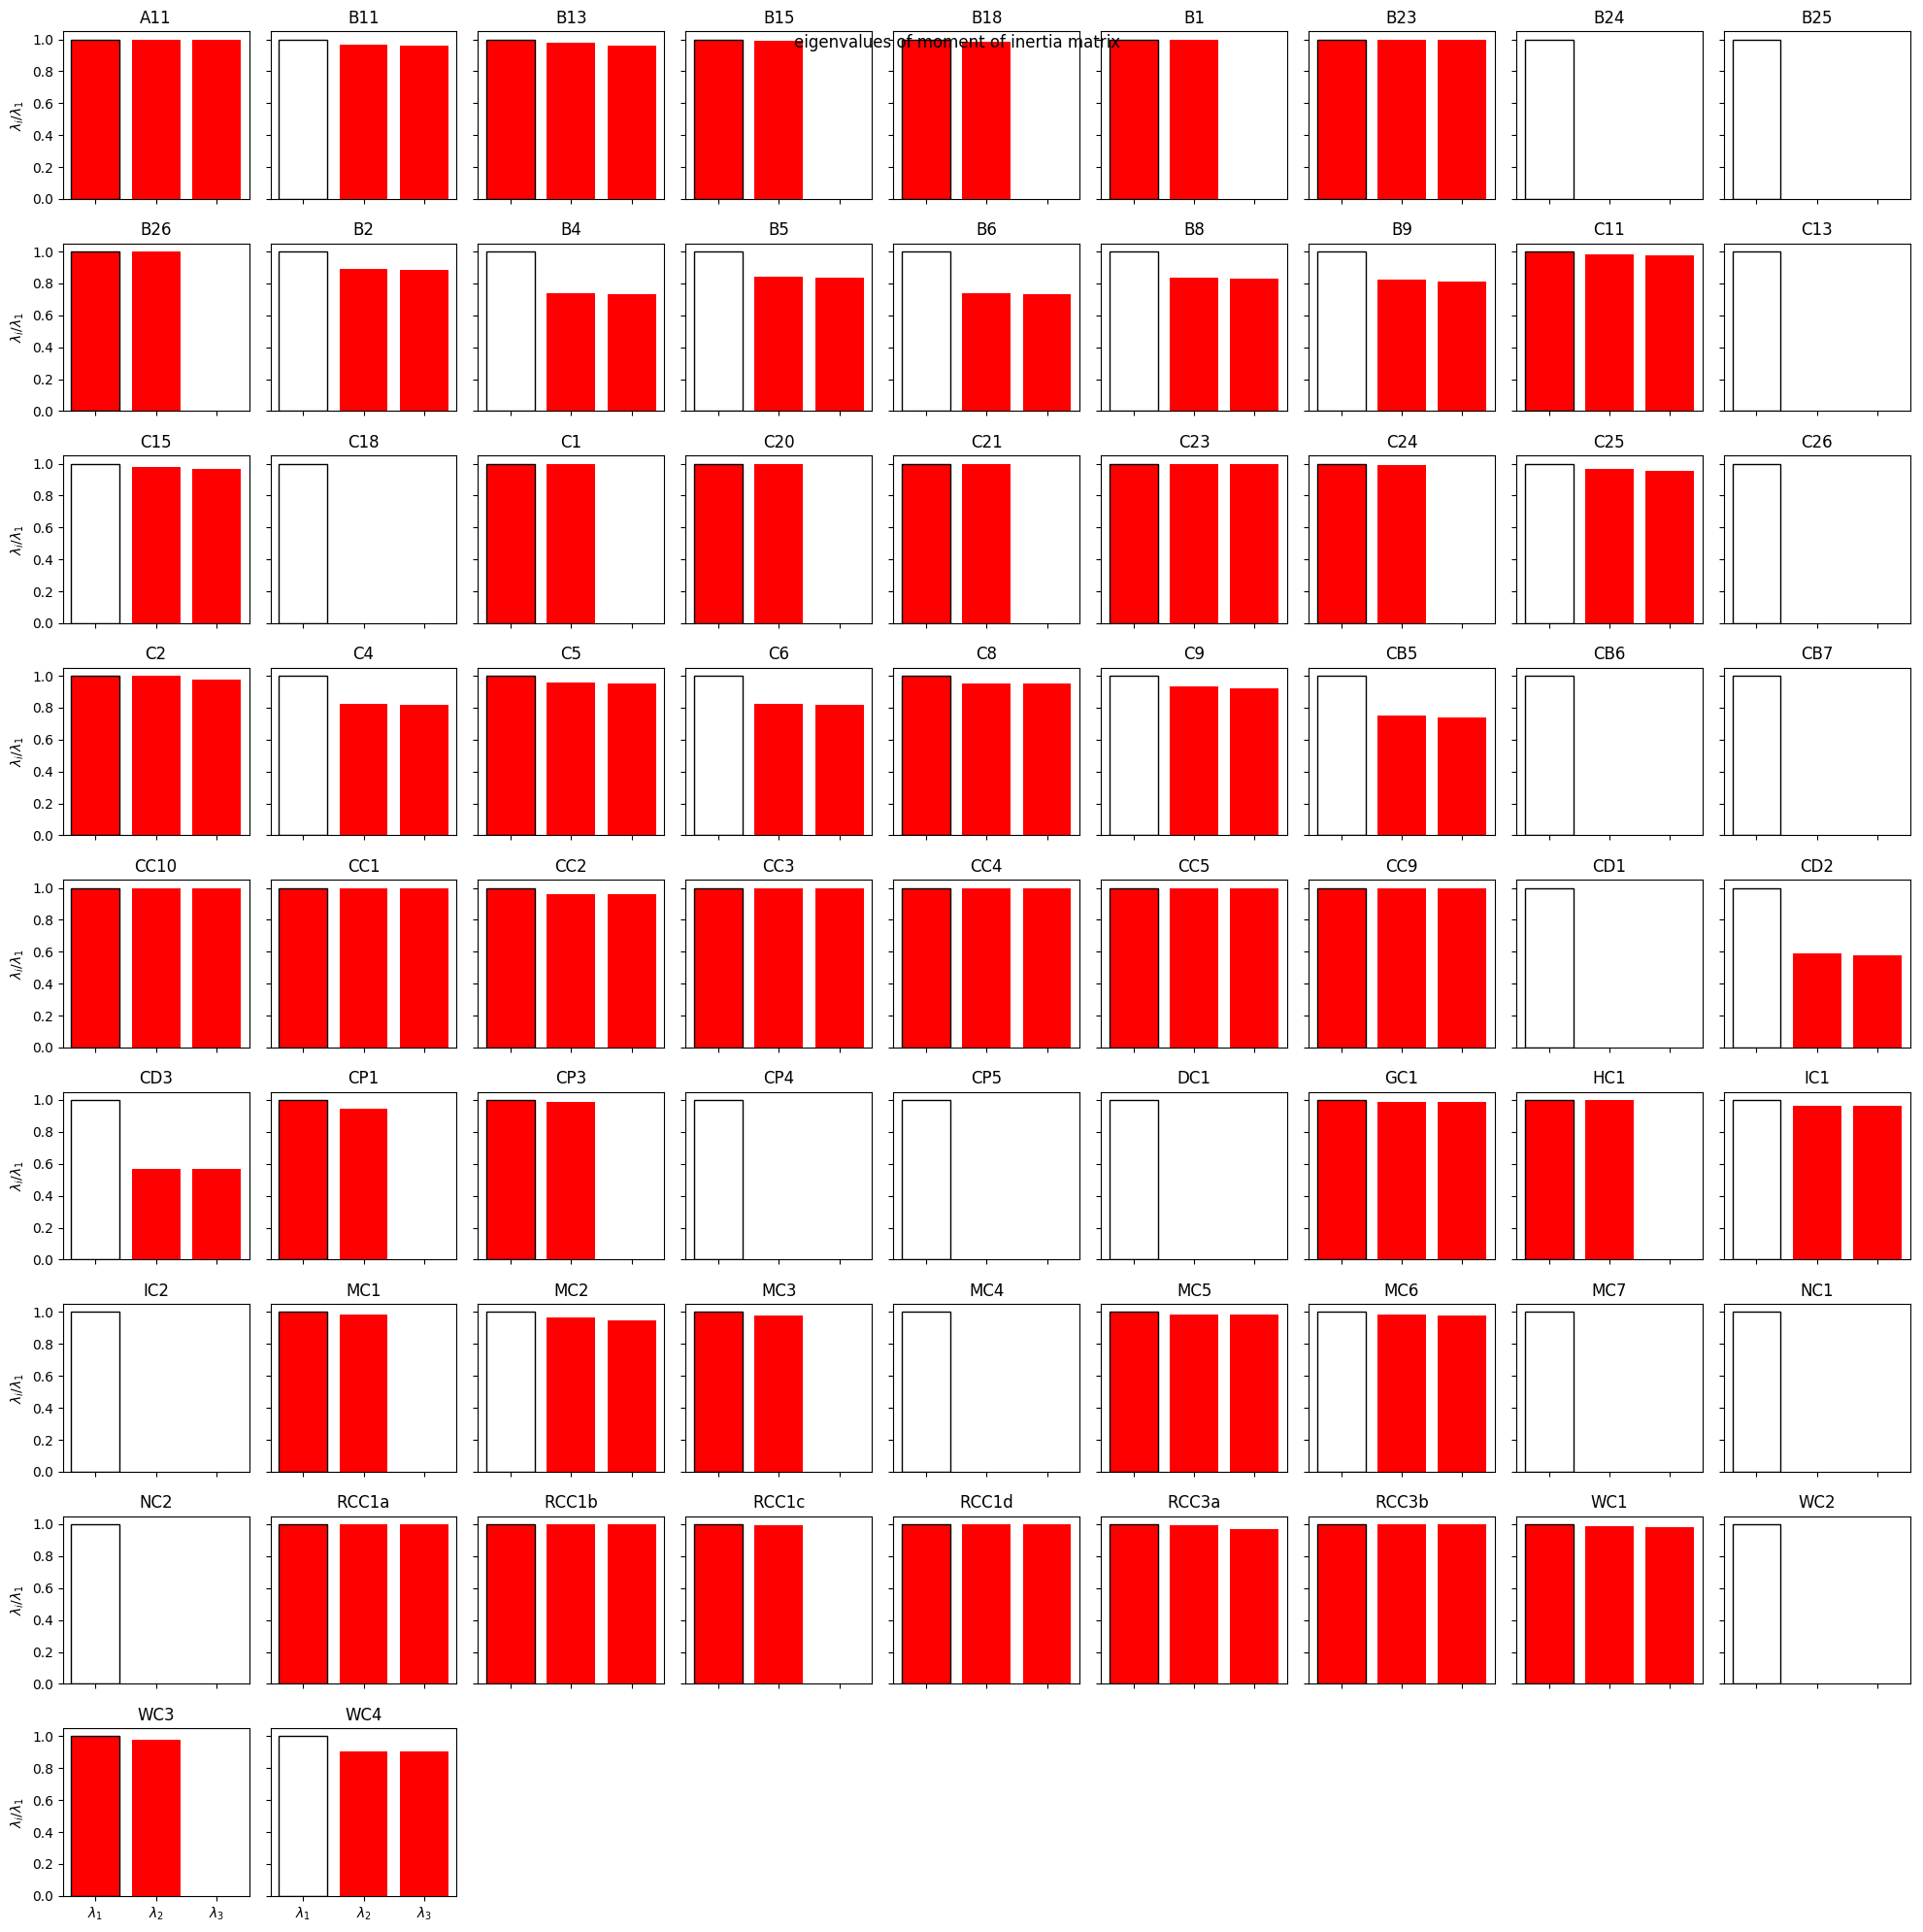

WC2 is robustly aligned using its principal axes of inertia


In [11]:
# list of cages that need alignment b/c principal axes of inertia agnostic
needs_further_alignment = Dict("xy" => String[], "yz" => String[], 
                               "xyz" => String[], "no" => String[])

printstyled("... if methyl group throws off orientation\n", color=:red)
nrows = ceil(Int, sqrt(length(cages))) # in the big plot
fig, axs = plt.plt[:subplots](nrows=nrows, ncols=nrows, figsize=(20, 20),
                          sharex=true, sharey=true)
cage_no = 0
for i = 1:nrows
    for j = 1:nrows
        cage_no += 1
        
        # blank panel if no cage for the panel
        if cage_no > length(cages)
            axs[i, j][:axis]("off")
            continue
        end
        
        # rotate cage so its principal axes of inertia aligned with Cartesian axes.
        atoms, x = rotational_inertia_aligned_cage(cages[cage_no])
        write_xyz(atoms, x, 
            "all_cages/" * cages[cage_no] * "_rotational_inertia_aligned.xyz")

        # compute new moment of inertia matrix to get moments of inertia
        #  about the princpal axes.
        λ, v, mi = diagonlize_moment_of_inertia(atoms, x)
        
        colorz = ["w", "w", "w"]
        
        # can a few e.g. C atoms at the periphery throw off the moment of inertia rankings?
        #  i.e. how sensitive is the alignment?
        cage_radius = maximum([norm(x[:, a]) for a = 1:size(x)[2]])
        Δλ_tol = 15.0 * cage_radius ^ 2
        xy_symmetry = isapprox(λ[1], λ[2], atol=Δλ_tol)
        yz_symmetry = isapprox(λ[2], λ[3], atol=Δλ_tol)
        if xy_symmetry && yz_symmetry
            push!(needs_further_alignment["xyz"], cages[cage_no])
            colorz[:] .= "r"
        elseif xy_symmetry
            push!(needs_further_alignment["xy"], cages[cage_no])
            colorz[1:2] .= "r"
        elseif yz_symmetry
            push!(needs_further_alignment["yz"], cages[cage_no])
            colorz[2:3] .= "r"
        else
            push!(needs_further_alignment["no"], cages[cage_no])
            @printf("Cage %s is robustly aligned using its principal axes of inertia\n", cages[cage_no])
            write_final_aligned_cage(atoms, x, cages[cage_no])
        end
       
        axs[i, j][:bar]([1, 2, 3], λ / λ[1], color=colorz, edgecolor="k")
        axs[i, j][:set_title](cages[cage_no])
        if j == 1
            axs[i, j][:set_ylabel]("\$ \\lambda_i / \\lambda_1\$")
        end
    end
end
plt.xticks([1, 2, 3], ["\$\\lambda_1\$", "\$\\lambda_2\$", "\$\\lambda_3\$"])
plt.suptitle("eigenvalues of moment of inertia matrix")
plt.tight_layout()
plt.savefig("moments_of_inertia.pdf", format="pdf")
plt.show()

### Point set registration to align cages where principal axes of inertia were agnostic

i.e. cages present in `needs_further_alignment`.

This function, given a reference cage, searches among a list of given unaligned cages for the one with the best alignment using the Coherent Drift algorithm. Then it aligns the cage with the best alignment with the reference cage `ref_cage`.

#### Compute matrix of likelihoods to play with different methods

`ℓ[i, j]`: -ve log likelihood for transforming cage `i` to align with cage `j`.

In [ ]:
ℓ = zeros(length(cages), length(cages)) # -ve log likelihood

@showprogress 1 "..." for i = 1:length(cages)
    _, y = centered_cage_coords(cages[i]) # y b/c we transform this one.
    for j = 1:length(cages)
        if i == j
            ℓ[i, j] = Inf
            continue
        end
        _, x = centered_cage_coords(cages[j])
        R, t, σ², ℓ[i, j] = CoherentPointDrift.rigid_point_set_registration(x, y, 
            w=0.0, σ²_tol=0.1, verbose=false, max_nb_em_steps=25)
    end
end

@save "ℓ_CPD.jld2" ℓ

#### idea 1: greedily align `xy`-, `yz`-, then `xyz`- degenerate-moments-cages with each other

For the cages that need aligned only in `xy` or `yz` plane, we start with an absolute reference cage (the first cage in the list), then search among all other cages *in this group* for the one with the closest alignment. We then successively align the best aligned with the reference cage. The idea is that this should preserve the orientation WRT the principal axis.

In [11]:
function find_best_cage_to_align_with_me(x::Array{Float64, 2},
                                         ys::Array{Array{Float64, 2}, 1};
                                         cage_names::Array{String, 1}=String[])
    nb_queries = length(ys)

    σ² = [Inf for i = 1:nb_queries]
    # loop thru all queries, see which is best aligned
    for (i, y) in enumerate(ys)
        if length(cage_names) > 0 
            println(cage_names[i])
        end
        if size(x) == size(y) && isapprox(x, y)
            error("cage == ref cage...")
        end
        
        # transformation is applied not to reference cage but the unaligned cage!
        R, t, σ²[i], ℓ = CoherentPointDrift.rigid_point_set_registration(x, y, 
            w=0.0, σ²_tol=0.05, q_tol=0.1, verbose=false, print_ending=false)
    end
    # which cage had the best alignment?
    return argmin(σ²)
end

find_best_cage_to_align_with_me (generic function with 1 method)

In [7]:
for pl in ["xy", "yz", "xyz"]
    printstyled("\nAligning cages with degeneracy " * pl * "\n", color=:blue)
    
    aligned = [false for i = 1:length(needs_further_alignment[pl])]
    
    align_to = needs_further_alignment[pl][1] # need to start somewhere; ref cage.
    println("\t\treference cage: ", align_to)
    aligned[needs_further_alignment[pl] .== align_to] .= true
    atoms, x = rotational_inertia_aligned_cage(align_to)
    write_final_aligned_cage(atoms, x, align_to)
    
    while sum(.! aligned) != 0
        # read in cage to which we will align. an already-aligned cage.
        #   x b/c we will keep this cage's coords
        atoms, x = aligned_and_centered_cage(align_to) # "me"
        printstyled("Finding a cage to align with me, " * align_to * " ...\n", color=:green)

        # build candidate y's among cages not yet aligned
        unaligned_cages = needs_further_alignment[pl][.! aligned]
        ys = [rotational_inertia_aligned_cage(cage)[2] for cage in unaligned_cages]

        # find cage that can be best aligned to me (`align_to`)
        i_aligns_with_me_best = find_best_cage_to_align_with_me(x, ys) #, cage_names=unaligned_cages)
        align_with_me = unaligned_cages[i_aligns_with_me_best]
        printstyled("\t" * align_with_me * " aligns best with me.\n", color=:red)
        
        # find transformation to align this cage with me (`align_to`)
        atoms, y = rotational_inertia_aligned_cage(align_with_me)
        println("\tCoherent point drift results for this alignment: ")
        R, t, σ², ℓ = CoherentPointDrift.rigid_point_set_registration(x, y, 
                w=0.0, σ²_tol=0.05, q_tol=0.1, verbose=false, print_ending=true)

        # transform, save.
        write_final_aligned_cage(atoms, R * y, align_with_me)  

        # update alignment status
        aligned[needs_further_alignment[pl] .== align_with_me] .= true

        # now me = this cage to keep pulling in cages
        align_to = align_with_me
    end
end


Aligning cages with degeneracy xy
		reference cage: B15
Finding a cage to align with me, B15 ...
	B18 aligns best with me.
	Coherent point drift results for this alignment: 
σ² = 0.027538, q = 37944.150053, reason for exit: variance below tol
Finding a cage to align with me, B18 ...
	B26 aligns best with me.
	Coherent point drift results for this alignment: 
σ² = 2.727468, q = 1055.330774, reason for exit: max EM steps reached
Finding a cage to align with me, B26 ...
	MC1 aligns best with me.
	Coherent point drift results for this alignment: 
σ² = 11.485478, q = 2169.346598, reason for exit: objective stopped decreasing
Finding a cage to align with me, MC1 ...
	C24 aligns best with me.
	Coherent point drift results for this alignment: 
σ² = 8.031232, q = 1382.036265, reason for exit: max EM steps reached
Finding a cage to align with me, C24 ...
	RCC1c aligns best with me.
	Coherent point drift results for this alignment: 
σ² = 7.142109, q = 1482.359446, reason for exit: objective stop

to treat xyz-degenerate cages diffferently?

In [14]:
aligned = [false for i = 1:length(needs_further_alignment["xyz"])]

printstyled("\nAligning cages with degeneracy xyz\n", color=:blue)

for align_me in needs_further_alignment["xyz"]
    printstyled("Finding a cage to align " * align_me * " to...\n", color=:green)
    
    if aligned[needs_further_alignment["xyz"] .== align_me][1]
        @printf("\t%s already been aligned!", align_me)
        continue
    end
    
    atoms, y = rotational_inertia_aligned_cage(align_me)
    
    # find best cage to align to out of xy, yz, and other xyz cages.
    candidates_to_align_to = vcat(needs_further_alignment["xy"], needs_further_alignment["yz"], 
        needs_further_alignment["xyz"])
    filter!(blah -> blah != align_me, candidates_to_align_to) # don't try to align to itself
    xs = [rotational_inertia_aligned_cage(cage)[2] for cage in candidates_to_align_to]
    
    i_align_to = find_best_cage_to_align_to(y, xs) #, cage_names=candidates_to_align_to)
    align_to = candidates_to_align_to[i_align_to]
    printstyled("\tbest aligned with " * align_to, color=:red)

    x = rand(2, 2) # ovewrite later
    # if the best cage to align to is in "xyz", align these two, remove from pool
    if align_to in needs_further_alignment["xyz"][.! aligned]
        _atoms, x = rotational_inertia_aligned_cage(align_to)
        write_final_aligned_cage(_atoms, x, align_to)
        aligned[needs_further_alignment["xyz"] .== align_to] .= true
        printstyled(", another cage w xyz degeneracy that hasn't been aligned. aligning this pair\n", color=:red)
    else # already aligned cage
        _, x = aligned_and_centered_cage(align_to)
        printstyled(", an already-aligned cage.\n", color=:red)
    end
        
    println("\tCoherent point drift results for this alignment: ")
    R, t, σ², ℓ = CoherentPointDrift.rigid_point_set_registration(x, y, 
                  w=0.0, σ²_tol=0.05, q_tol=0.1, verbose=false, print_ending=true)
    write_final_aligned_cage(atoms, R * y, align_me)

    aligned[needs_further_alignment["xyz"] .== align_me] .= true
end


Aligning cages with degeneracy xyz
Finding a cage to align A11 to...
	best aligned with B1, an already-aligned cage.
	Coherent point drift results for this alignment: 
σ² = 0.000001, q = 816624904.509112, reason for exit: variance below tol
Finding a cage to align B13 to...
	best aligned with HC1, an already-aligned cage.
	Coherent point drift results for this alignment: 
σ² = 0.000001, q = 240326133.737498, reason for exit: variance below tol
Finding a cage to align B23 to...
	best aligned with B1, an already-aligned cage.
	Coherent point drift results for this alignment: 
σ² = 0.000001, q = 769395897.838674, reason for exit: variance below tol
Finding a cage to align C11 to...
	best aligned with B1, an already-aligned cage.
	Coherent point drift results for this alignment: 
σ² = 0.000001, q = 771126437.456124, reason for exit: variance below tol
Finding a cage to align C23 to...
	best aligned with B1, an already-aligned cage.
	Coherent point drift results for this alignment: 
σ² = 0

InterruptException: InterruptException:

#### idea 2 align all of these to each other, only the first cage align with some cage in the PAI-robust set.
pick similar pair, align those, then next most similar pair...

In [ ]:
all_needs_further_alignment = vcat(needs_further_alignment["xy"],
                                   needs_further_alignment["yz"],
                                   needs_further_alignment["xyz"])

ℓ = zeros(length(all_needs_further_alignment), length(all_needs_further_alignment)) # -ve log likelihood

@showprogress 1 "..." for i = 1:length(all_needs_further_alignment)
    _, y = centered_cage_coords(all_needs_further_alignment[i]) # y b/c we transform this one.
    for j = 1:length(all_needs_further_alignment)
        if i == j
            ℓ[i, j] = Inf
            continue
        end
        _, x = centered_cage_coords(all_needs_further_alignment[j])
        R, t, σ², ℓ[i, j] = CoherentPointDrift.rigid_point_set_registration(x, y, 
            w=0.0, σ²_tol=0.1, verbose=false, max_nb_em_steps=25)
    end
end

@save "ℓ_CPD.jld2" ℓ

σ² = 5.475195, q = 989.421759, reason for exit: max EM steps reached
σ² = 0.000001, q = 888656624.044358, reason for exit: variance below tol
σ² = 14.156515, q = 2255.521303, reason for exit: max EM steps reached
σ² = 0.000001, q = 1181893228.488666, reason for exit: variance below tol
σ² = 0.000001, q = 1372679037.425769, reason for exit: variance below tol
σ² = 0.000001, q = 1491306591.167970, reason for exit: variance below tol
σ² = 2.797630, q = 1235.100668, reason for exit: max EM steps reached
σ² = 0.000001, q = 985276339.553128, reason for exit: variance below tol
σ² = 0.000001, q = 717625696.436308, reason for exit: variance below tol
σ² = 0.000001, q = 1831932896.728468, reason for exit: variance below tol
σ² = 5.976499, q = 1207.191551, reason for exit: max EM steps reached
σ² = 0.000001, q = 1954939952.610771, reason for exit: variance below tol
σ² = 0.421969, q = 2584.940128, reason for exit: max EM steps reached
σ² = 0.583705, q = 2289.372594, reason for exit: max EM steps

...  2%|█                                               |  ETA: 0:58:36

σ² = 0.000001, q = 420883415.969154, reason for exit: variance below tol
σ² = 0.000001, q = 1022589322.698682, reason for exit: variance below tol
σ² = 7.767520, q = 2047.162755, reason for exit: max EM steps reached
σ² = 0.000001, q = 1326680312.798924, reason for exit: variance below tol
σ² = 0.000001, q = 1634530593.735796, reason for exit: variance below tol
σ² = 0.000001, q = 1704870319.740678, reason for exit: variance below tol
σ² = 0.392213, q = 3771.805301, reason for exit: max EM steps reached
σ² = 0.000001, q = 1327107838.485646, reason for exit: variance below tol
σ² = 0.000001, q = 990932372.537639, reason for exit: variance below tol
σ² = 0.000001, q = 2167516360.875203, reason for exit: variance below tol
σ² = 2.085582, q = 947.405383, reason for exit: max EM steps reached
σ² = 0.000001, q = 2116326128.893591, reason for exit: variance below tol
σ² = 0.000001, q = 3235574066.367057, reason for exit: variance below tol
σ² = 0.000001, q = 2446137569.419249, reason for exit

...  4%|██                                              |  ETA: 0:52:14

σ² = 23.206144, q = 1620.963286, reason for exit: max EM steps reached
σ² = 32.919720, q = 1848.523453, reason for exit: max EM steps reached
σ² = 40.861979, q = 2957.257649, reason for exit: max EM steps reached
σ² = 0.651366, q = 26.151405, reason for exit: max EM steps reached
σ² = 3.277855, q = 364.006021, reason for exit: max EM steps reached
σ² = 3.242017, q = 367.464238, reason for exit: objective stopped decreasing
σ² = 23.516620, q = 2077.019456, reason for exit: max EM steps reached
σ² = 0.883450, q = 308.330492, reason for exit: max EM steps reached
σ² = 0.016514, q = 4647.374858, reason for exit: variance below tol
σ² = 2.753395, q = 413.449453, reason for exit: max EM steps reached
σ² = 28.696772, q = 1937.289317, reason for exit: max EM steps reached
σ² = 8.303202, q = 643.297454, reason for exit: max EM steps reached
σ² = 14.919651, q = 2439.726826, reason for exit: max EM steps reached
σ² = 13.409202, q = 1815.427725, reason for exit: max EM steps reached
σ² = 11.598232

...  5%|███                                             |  ETA: 0:53:14

σ² = 1.882189, q = 956.052071, reason for exit: max EM steps reached
σ² = 2.754063, q = 1028.158855, reason for exit: max EM steps reached
σ² = 0.000001, q = 1084965500.144277, reason for exit: variance below tol
σ² = 0.000001, q = 1320934299.183789, reason for exit: variance below tol
σ² = 0.000001, q = 1379714841.349677, reason for exit: variance below tol
σ² = 0.000001, q = 1588463082.622041, reason for exit: variance below tol
σ² = 0.000001, q = 575949122.990085, reason for exit: variance below tol
σ² = 0.000001, q = 1271651039.668393, reason for exit: variance below tol
σ² = 0.000001, q = 912541734.817801, reason for exit: variance below tol
σ² = 0.000001, q = 1687719384.690011, reason for exit: variance below tol
σ² = 3.725856, q = 1181.845771, reason for exit: max EM steps reached
σ² = 0.000001, q = 2028402853.267537, reason for exit: variance below tol
σ² = 0.096332, q = 24186.595752, reason for exit: variance below tol
σ² = 0.000001, q = 1782000036.719900, reason for exit: var

...  7%|███                                             |  ETA: 0:52:40

σ² = 22.059204, q = 1605.336675, reason for exit: max EM steps reached
σ² = 31.800439, q = 1838.408277, reason for exit: max EM steps reached
σ² = 0.000001, q = 9268389.123818, reason for exit: variance below tol
σ² = 39.626931, q = 2942.525990, reason for exit: max EM steps reached
σ² = 1.459142, q = 211.855156, reason for exit: objective stopped decreasing
σ² = 1.411321, q = 211.299182, reason for exit: objective stopped decreasing
σ² = 22.408503, q = 2059.738970, reason for exit: max EM steps reached
σ² = 0.728405, q = 277.808101, reason for exit: max EM steps reached
σ² = 0.030546, q = 2581.923170, reason for exit: variance below tol
σ² = 2.088324, q = 365.299517, reason for exit: max EM steps reached
σ² = 27.251968, q = 1915.722250, reason for exit: max EM steps reached
σ² = 7.569633, q = 630.116945, reason for exit: max EM steps reached
σ² = 13.588009, q = 2379.799382, reason for exit: max EM steps reached
σ² = 11.832153, q = 1754.578332, reason for exit: max EM steps reached
σ² 

...  9%|████                                            |  ETA: 0:53:19

σ² = 21.838990, q = 1630.589344, reason for exit: max EM steps reached
σ² = 30.295078, q = 1828.893307, reason for exit: max EM steps reached
σ² = 0.049323, q = 1159.424798, reason for exit: variance below tol
σ² = 37.868057, q = 2924.504222, reason for exit: max EM steps reached
σ² = 0.022320, q = 2963.531782, reason for exit: variance below tol
σ² = 0.099436, q = -70.553193, reason for exit: variance below tol
σ² = 22.106933, q = 2086.493629, reason for exit: max EM steps reached
σ² = 1.305640, q = 325.426232, reason for exit: max EM steps reached
σ² = 0.430576, q = 175.266298, reason for exit: max EM steps reached
σ² = 2.542193, q = 454.978777, reason for exit: max EM steps reached
σ² = 26.205925, q = 1917.726784, reason for exit: max EM steps reached
σ² = 7.732155, q = 664.850598, reason for exit: max EM steps reached
σ² = 13.277144, q = 2422.248156, reason for exit: max EM steps reached
σ² = 10.423820, q = 1709.982343, reason for exit: max EM steps reached
σ² = 10.488051, q = 1034

... 11%|█████                                           |  ETA: 0:53:29

σ² = 22.271798, q = 1642.281520, reason for exit: max EM steps reached
σ² = 31.780439, q = 1861.598586, reason for exit: max EM steps reached
σ² = 0.282011, q = 126.367696, reason for exit: max EM steps reached
σ² = 38.380379, q = 2937.368023, reason for exit: max EM steps reached
σ² = 0.294024, q = 134.278984, reason for exit: objective stopped decreasing
σ² = 0.053174, q = 191.691474, reason for exit: variance below tol
σ² = 21.885635, q = 2080.135724, reason for exit: max EM steps reached
σ² = 1.575785, q = 316.035087, reason for exit: max EM steps reached
σ² = 0.878150, q = 157.863662, reason for exit: max EM steps reached
σ² = 3.261447, q = 516.457390, reason for exit: max EM steps reached
σ² = 26.287843, q = 1918.409260, reason for exit: max EM steps reached
σ² = 8.702671, q = 704.774436, reason for exit: max EM steps reached
σ² = 14.277600, q = 2496.867553, reason for exit: max EM steps reached
σ² = 10.986253, q = 1743.891603, reason for exit: max EM steps reached
σ² = 11.445751

... 12%|██████                                          |  ETA: 0:53:31

σ² = 2.053289, q = 889.182691, reason for exit: max EM steps reached
σ² = 4.075633, q = 1072.134183, reason for exit: max EM steps reached
σ² = 0.000001, q = 788710935.625340, reason for exit: variance below tol
σ² = 11.487123, q = 2009.604117, reason for exit: objective stopped decreasing
σ² = 0.000001, q = 1019500377.050538, reason for exit: variance below tol
σ² = 0.000001, q = 1136823465.322777, reason for exit: variance below tol
σ² = 0.000001, q = 1311621695.487799, reason for exit: variance below tol
σ² = 0.000001, q = 841233851.577240, reason for exit: variance below tol
σ² = 0.000001, q = 568677825.357544, reason for exit: variance below tol
σ² = 0.000001, q = 1374390740.656571, reason for exit: variance below tol
σ² = 8.426086, q = 1416.715293, reason for exit: max EM steps reached
σ² = 0.060249, q = 3893.383229, reason for exit: variance below tol
σ² = 1.459677, q = 1480.675048, reason for exit: max EM steps reached
σ² = 1.244052, q = 1187.644749, reason for exit: max EM ste

... 14%|███████                                         |  ETA: 0:54:58

σ² = 24.759209, q = 1656.794928, reason for exit: max EM steps reached
σ² = 34.233576, q = 1869.444496, reason for exit: max EM steps reached
σ² = 1.227214, q = 184.297397, reason for exit: max EM steps reached
σ² = 41.950609, q = 2976.343561, reason for exit: max EM steps reached
σ² = 2.126792, q = 303.551601, reason for exit: max EM steps reached
σ² = 5.114571, q = 467.656994, reason for exit: max EM steps reached
σ² = 3.968225, q = 423.267088, reason for exit: max EM steps reached
σ² = 24.699909, q = 2107.143470, reason for exit: max EM steps reached
σ² = 0.216992, q = 52.727206, reason for exit: max EM steps reached
σ² = 4.166272, q = 519.066215, reason for exit: max EM steps reached
σ² = 29.725114, q = 1954.410171, reason for exit: max EM steps reached
σ² = 10.680972, q = 727.896820, reason for exit: max EM steps reached
σ² = 16.174330, q = 2503.381751, reason for exit: max EM steps reached
σ² = 14.291649, q = 1851.350101, reason for exit: max EM steps reached
σ² = 13.273921, q = 

... 16%|████████                                        |  ETA: 0:53:15

σ² = 26.047323, q = 1674.359867, reason for exit: max EM steps reached
σ² = 35.584622, q = 1884.325677, reason for exit: max EM steps reached
σ² = 2.032374, q = 242.070126, reason for exit: max EM steps reached
σ² = 43.381205, q = 2997.134545, reason for exit: max EM steps reached
σ² = 3.404891, q = 373.869914, reason for exit: max EM steps reached
σ² = 5.981826, q = 484.238990, reason for exit: max EM steps reached
σ² = 5.889002, q = 485.219389, reason for exit: max EM steps reached
σ² = 26.076961, q = 2133.108713, reason for exit: max EM steps reached
σ² = 1.631663, q = 260.429814, reason for exit: max EM steps reached
σ² = 5.477372, q = 576.652648, reason for exit: max EM steps reached
σ² = 31.280777, q = 1978.932650, reason for exit: max EM steps reached
σ² = 11.270681, q = 724.368080, reason for exit: max EM steps reached
σ² = 17.600805, q = 2560.885423, reason for exit: max EM steps reached
σ² = 15.982972, q = 1909.543611, reason for exit: max EM steps reached
σ² = 14.356499, q =

... 18%|████████                                        |  ETA: 0:50:25

σ² = 17.957345, q = 1497.407766, reason for exit: max EM steps reached
σ² = 27.641339, q = 1760.140151, reason for exit: max EM steps reached
σ² = 0.172025, q = 18.932958, reason for exit: max EM steps reached
σ² = 35.832343, q = 2858.651376, reason for exit: max EM steps reached
σ² = 0.396003, q = 29.005330, reason for exit: max EM steps reached
σ² = 1.960649, q = 295.049876, reason for exit: max EM steps reached
σ² = 1.912774, q = 292.605659, reason for exit: max EM steps reached
σ² = 18.692246, q = 1944.905298, reason for exit: max EM steps reached
σ² = 0.315789, q = 229.831385, reason for exit: max EM steps reached
σ² = 0.091795, q = 590.790817, reason for exit: variance below tol
σ² = 23.943959, q = 1843.856584, reason for exit: max EM steps reached
σ² = 4.198201, q = 490.289882, reason for exit: max EM steps reached
σ² = 9.975920, q = 2130.602175, reason for exit: max EM steps reached
σ² = 10.434371, q = 1704.758510, reason for exit: max EM steps reached
σ² = 6.990358, q = 862.19

... 19%|█████████                                       |  ETA: 0:50:06

σ² = 1.927714, q = 652.465758, reason for exit: max EM steps reached
σ² = 6.974955, q = 1132.131556, reason for exit: max EM steps reached
σ² = 0.000001, q = 883497786.148768, reason for exit: variance below tol
σ² = 11.741941, q = 2192.479661, reason for exit: max EM steps reached
σ² = 0.000001, q = 1169782838.618998, reason for exit: variance below tol
σ² = 0.000001, q = 1523515117.483870, reason for exit: variance below tol
σ² = 0.000001, q = 1500200547.048853, reason for exit: variance below tol
σ² = 3.425675, q = 1437.329681, reason for exit: max EM steps reached
σ² = 0.000001, q = 1029473192.865160, reason for exit: variance below tol
σ² = 0.000001, q = 684596558.837317, reason for exit: variance below tol
σ² = 0.000001, q = 1541837151.752823, reason for exit: variance below tol
σ² = 0.000001, q = 1804934305.379687, reason for exit: variance below tol
σ² = 0.136233, q = 7697.426855, reason for exit: max EM steps reached
σ² = 0.169742, q = 8557.817068, reason for exit: max EM step

... 21%|██████████                                      |  ETA: 0:49:27

σ² = 11.167857, q = 1295.521281, reason for exit: max EM steps reached
σ² = 18.945349, q = 1559.937783, reason for exit: max EM steps reached
σ² = 0.092798, q = 1389.114757, reason for exit: variance below tol
σ² = 27.676896, q = 2659.503620, reason for exit: max EM steps reached
σ² = 0.475507, q = 427.804543, reason for exit: max EM steps reached
σ² = 0.478114, q = 426.144524, reason for exit: max EM steps reached
σ² = 0.428610, q = 462.648867, reason for exit: max EM steps reached
σ² = 12.318398, q = 1729.950875, reason for exit: max EM steps reached
σ² = 0.349944, q = 834.249672, reason for exit: max EM steps reached
σ² = 0.000001, q = 473787307.158548, reason for exit: variance below tol
σ² = 0.448434, q = 426.809054, reason for exit: max EM steps reached
σ² = 17.380619, q = 1696.903474, reason for exit: max EM steps reached
σ² = 6.718698, q = 2053.253273, reason for exit: max EM steps reached
σ² = 6.342281, q = 1556.285994, reason for exit: max EM steps reached
σ² = 3.274954, q = 

... 23%|███████████                                     |  ETA: 0:48:41

σ² = 5.821317, q = 1080.661417, reason for exit: max EM steps reached
σ² = 14.408653, q = 1474.940205, reason for exit: max EM steps reached
σ² = 0.217045, q = 165.094855, reason for exit: max EM steps reached
σ² = 23.346787, q = 2574.618855, reason for exit: max EM steps reached
σ² = 0.368646, q = 153.244075, reason for exit: max EM steps reached
σ² = 0.438825, q = 236.031176, reason for exit: max EM steps reached
σ² = 0.340514, q = 182.933398, reason for exit: max EM steps reached
σ² = 7.307256, q = 1498.247476, reason for exit: max EM steps reached
σ² = 0.150486, q = 254.459239, reason for exit: max EM steps reached
σ² = 0.118075, q = 355.964690, reason for exit: max EM steps reached
σ² = 0.950454, q = 301.343325, reason for exit: max EM steps reached
σ² = 9.731878, q = 1397.326494, reason for exit: max EM steps reached
σ² = 1.043274, q = 321.318805, reason for exit: max EM steps reached
σ² = 2.077675, q = 948.731533, reason for exit: max EM steps reached
σ² = 1.025354, q = 455.9521

... 25%|████████████                                    |  ETA: 0:52:45

σ² = 10.789821, q = 1328.241953, reason for exit: max EM steps reached
σ² = 19.640551, q = 1633.788728, reason for exit: max EM steps reached
σ² = 0.002456, q = 35344.144170, reason for exit: variance below tol
σ² = 26.927716, q = 2688.533370, reason for exit: max EM steps reached
σ² = 0.034895, q = 3714.485694, reason for exit: variance below tol
σ² = 0.957137, q = 213.025102, reason for exit: max EM steps reached
σ² = 0.067492, q = 2296.560817, reason for exit: variance below tol
σ² = 10.797428, q = 1689.188863, reason for exit: max EM steps reached
σ² = 0.000001, q = 121060983.170492, reason for exit: variance below tol
σ² = 0.000001, q = 401484025.717250, reason for exit: variance below tol
σ² = 0.869395, q = 246.692889, reason for exit: max EM steps reached
σ² = 14.421626, q = 1611.887563, reason for exit: max EM steps reached
σ² = 1.933753, q = 385.308838, reason for exit: max EM steps reached
σ² = 3.944773, q = 1645.296047, reason for exit: max EM steps reached
σ² = 4.200444, q 

... 26%|█████████████                                   |  ETA: 0:53:49

σ² = 8.435518, q = 1134.039339, reason for exit: max EM steps reached
σ² = 15.953013, q = 1454.759503, reason for exit: objective stopped decreasing
σ² = 0.000001, q = 716086228.696319, reason for exit: variance below tol
σ² = 24.989377, q = 2580.750354, reason for exit: max EM steps reached
σ² = 0.000001, q = 971277351.306132, reason for exit: variance below tol
σ² = 0.000001, q = 397612425.561089, reason for exit: variance below tol
σ² = 0.000001, q = 437078639.995352, reason for exit: variance below tol
σ² = 9.881364, q = 1613.946696, reason for exit: max EM steps reached
σ² = 0.000001, q = 880070809.536674, reason for exit: variance below tol
σ² = 0.000001, q = 611846351.545256, reason for exit: variance below tol
σ² = 0.000001, q = 475029422.760595, reason for exit: variance below tol
σ² = 13.554986, q = 1529.180816, reason for exit: max EM steps reached
σ² = 0.437162, q = 470.394516, reason for exit: max EM steps reached
σ² = 4.095983, q = 1672.256408, reason for exit: max EM ste

... 28%|█████████████                                   |  ETA: 0:52:20

σ² = 23.083156, q = 1619.014843, reason for exit: max EM steps reached
σ² = 32.795003, q = 1846.957955, reason for exit: max EM steps reached
σ² = 0.000001, q = 2061299.011596, reason for exit: variance below tol
σ² = 40.733716, q = 2955.089621, reason for exit: max EM steps reached
σ² = 0.617833, q = 15.668152, reason for exit: max EM steps reached
σ² = 3.262111, q = 362.454572, reason for exit: max EM steps reached
σ² = 3.222889, q = 365.681946, reason for exit: max EM steps reached
σ² = 23.384611, q = 2074.199326, reason for exit: max EM steps reached
σ² = 0.898166, q = 309.949247, reason for exit: max EM steps reached
σ² = 0.054534, q = 1351.921689, reason for exit: variance below tol
σ² = 2.651616, q = 406.935845, reason for exit: max EM steps reached
σ² = 28.619540, q = 1936.446670, reason for exit: max EM steps reached
σ² = 8.095586, q = 637.924391, reason for exit: max EM steps reached
σ² = 14.832756, q = 2437.637800, reason for exit: max EM steps reached
σ² = 13.354982, q = 18

... 30%|██████████████                                  |  ETA: 0:50:07

σ² = 13.416136, q = 1410.660069, reason for exit: max EM steps reached
σ² = 20.865071, q = 1644.929171, reason for exit: objective stopped decreasing
σ² = 0.094399, q = -39.656698, reason for exit: variance below tol
σ² = 28.814572, q = 2706.833963, reason for exit: max EM steps reached
σ² = 0.603911, q = 10.957232, reason for exit: max EM steps reached
σ² = 3.248668, q = 362.602763, reason for exit: max EM steps reached
σ² = 3.222197, q = 366.253973, reason for exit: max EM steps reached
σ² = 13.674122, q = 1809.894729, reason for exit: max EM steps reached
σ² = 0.910158, q = 309.732000, reason for exit: max EM steps reached
σ² = 0.028343, q = 2718.506994, reason for exit: variance below tol
σ² = 1.769642, q = 341.390965, reason for exit: max EM steps reached
σ² = 20.224085, q = 1792.233199, reason for exit: max EM steps reached
σ² = 3.341748, q = 485.213640, reason for exit: max EM steps reached
σ² = 8.696624, q = 2130.746659, reason for exit: max EM steps reached
σ² = 11.139244, q =

... 32%|███████████████                                 |  ETA: 0:48:35

σ² = 17.089944, q = 1484.089293, reason for exit: max EM steps reached
σ² = 25.975410, q = 1729.914636, reason for exit: max EM steps reached
σ² = 0.051724, q = -106.353678, reason for exit: variance below tol
σ² = 34.023302, q = 2815.355957, reason for exit: max EM steps reached
σ² = 0.589095, q = 6.401550, reason for exit: max EM steps reached
σ² = 3.196288, q = 361.021099, reason for exit: max EM steps reached
σ² = 3.196937, q = 365.440301, reason for exit: objective stopped decreasing
σ² = 17.390987, q = 1905.385196, reason for exit: max EM steps reached
σ² = 0.988237, q = 318.992141, reason for exit: max EM steps reached
σ² = 0.012498, q = 6329.340481, reason for exit: variance below tol
σ² = 1.129088, q = 244.336630, reason for exit: max EM steps reached
σ² = 24.164660, q = 1862.668076, reason for exit: max EM steps reached
σ² = 4.150791, q = 501.789274, reason for exit: max EM steps reached
σ² = 10.382749, q = 2195.324084, reason for exit: max EM steps reached
σ² = 11.693645, q 

... 33%|████████████████                                |  ETA: 0:46:57

σ² = 14.698417, q = 1436.611113, reason for exit: max EM steps reached
σ² = 22.375100, q = 1671.234787, reason for exit: max EM steps reached
σ² = 0.058364, q = -94.640326, reason for exit: variance below tol
σ² = 30.035836, q = 2733.432160, reason for exit: max EM steps reached
σ² = 0.595565, q = 8.918353, reason for exit: max EM steps reached
σ² = 3.203211, q = 361.579002, reason for exit: max EM steps reached
σ² = 3.204216, q = 365.978822, reason for exit: objective stopped decreasing
σ² = 14.873496, q = 1842.083727, reason for exit: max EM steps reached
σ² = 0.759859, q = 279.521575, reason for exit: max EM steps reached
σ² = 0.090352, q = 783.892072, reason for exit: variance below tol
σ² = 1.806026, q = 347.637726, reason for exit: max EM steps reached
σ² = 22.140122, q = 1835.457206, reason for exit: max EM steps reached
σ² = 4.052296, q = 509.625836, reason for exit: max EM steps reached
σ² = 10.008482, q = 2219.094732, reason for exit: max EM steps reached
σ² = 11.363087, q = 

... 35%|█████████████████                               |  ETA: 0:45:30

σ² = 17.612582, q = 1494.788343, reason for exit: max EM steps reached
σ² = 26.704472, q = 1742.247738, reason for exit: max EM steps reached
σ² = 0.046343, q = -86.844486, reason for exit: variance below tol
σ² = 34.775736, q = 2830.985481, reason for exit: max EM steps reached
σ² = 0.590299, q = 7.007600, reason for exit: max EM steps reached
σ² = 3.198614, q = 361.321284, reason for exit: max EM steps reached
σ² = 3.198930, q = 365.689555, reason for exit: objective stopped decreasing
σ² = 17.943916, q = 1920.023464, reason for exit: max EM steps reached
σ² = 0.751098, q = 277.702667, reason for exit: max EM steps reached
σ² = 0.083627, q = 853.433814, reason for exit: variance below tol
σ² = 1.801588, q = 345.930540, reason for exit: max EM steps reached
σ² = 24.412530, q = 1863.541060, reason for exit: max EM steps reached
σ² = 4.572455, q = 523.146929, reason for exit: max EM steps reached
σ² = 11.319064, q = 2270.028898, reason for exit: max EM steps reached
σ² = 11.816660, q = 

... 37%|██████████████████                              |  ETA: 0:44:00

σ² = 18.756742, q = 1521.284706, reason for exit: max EM steps reached
σ² = 28.100617, q = 1767.172218, reason for exit: max EM steps reached
σ² = 0.059073, q = -101.501349, reason for exit: variance below tol
σ² = 36.144891, q = 2860.431692, reason for exit: max EM steps reached
σ² = 0.598728, q = 9.932202, reason for exit: max EM steps reached
σ² = 3.212248, q = 361.889294, reason for exit: max EM steps reached
σ² = 3.209418, q = 366.119354, reason for exit: max EM steps reached
σ² = 19.099478, q = 1953.838603, reason for exit: max EM steps reached
σ² = 0.751952, q = 274.606104, reason for exit: max EM steps reached
σ² = 0.077559, q = 929.760688, reason for exit: variance below tol
σ² = 1.769519, q = 339.224962, reason for exit: max EM steps reached
σ² = 25.545078, q = 1885.231204, reason for exit: max EM steps reached
σ² = 4.956009, q = 533.916754, reason for exit: max EM steps reached
σ² = 11.785692, q = 2283.902574, reason for exit: max EM steps reached
σ² = 12.112578, q = 1777.24

... 39%|███████████████████                             |  ETA: 0:42:25

σ² = 0.370426, q = 168.191126, reason for exit: max EM steps reached
σ² = 3.874186, q = 864.379600, reason for exit: max EM steps reached
σ² = 0.000001, q = 931696569.391450, reason for exit: variance below tol
σ² = 11.168565, q = 2134.728840, reason for exit: max EM steps reached
σ² = 0.000001, q = 1227941535.551392, reason for exit: variance below tol
σ² = 0.000001, q = 1425646196.556647, reason for exit: variance below tol
σ² = 0.000001, q = 1557695294.356372, reason for exit: variance below tol
σ² = 1.711806, q = 1259.779181, reason for exit: max EM steps reached
σ² = 0.000001, q = 1067869173.268247, reason for exit: variance below tol
σ² = 0.000001, q = 819002746.133011, reason for exit: variance below tol
σ² = 0.000001, q = 1751062361.083824, reason for exit: variance below tol
σ² = 5.165960, q = 1163.375790, reason for exit: max EM steps reached
σ² = 0.000001, q = 1996570262.009123, reason for exit: variance below tol
σ² = 0.071716, q = 25277.663161, reason for exit: variance be

... 40%|███████████████████                             |  ETA: 0:40:56

σ² = 1.799021, q = 1058.576457, reason for exit: max EM steps reached
σ² = 1.933214, q = 1071.379141, reason for exit: max EM steps reached
σ² = 0.000001, q = 962270831.317559, reason for exit: variance below tol
σ² = 3.290942, q = 1214.782320, reason for exit: max EM steps reached
σ² = 0.000001, q = 1192179387.576732, reason for exit: variance below tol
σ² = 0.000001, q = 1242260809.182898, reason for exit: variance below tol
σ² = 0.000001, q = 1482185278.779105, reason for exit: variance below tol
σ² = 0.000001, q = 626004796.160352, reason for exit: variance below tol
σ² = 0.000001, q = 1098997936.664045, reason for exit: variance below tol
σ² = 0.000001, q = 804616403.332429, reason for exit: variance below tol
σ² = 0.000001, q = 1504543539.252789, reason for exit: variance below tol
σ² = 5.304094, q = 1298.432567, reason for exit: max EM steps reached
σ² = 0.080732, q = 4043.652571, reason for exit: variance below tol
σ² = 0.720282, q = 2351.904862, reason for exit: max EM steps r

... 42%|████████████████████                            |  ETA: 0:39:43

σ² = 12.318579, q = 1372.736236, reason for exit: max EM steps reached
σ² = 20.166797, q = 1626.690561, reason for exit: max EM steps reached
σ² = 0.000001, q = 3855677.036045, reason for exit: variance below tol
σ² = 28.225086, q = 2690.095678, reason for exit: max EM steps reached
σ² = 0.000001, q = 2354181.097039, reason for exit: variance below tol
σ² = 1.462690, q = 212.239638, reason for exit: max EM steps reached
σ² = 1.411466, q = 210.937643, reason for exit: objective stopped decreasing
σ² = 12.641845, q = 1769.434943, reason for exit: max EM steps reached
σ² = 0.742197, q = 283.467525, reason for exit: max EM steps reached
σ² = 0.029390, q = 2672.784028, reason for exit: variance below tol
σ² = 1.263209, q = 289.098798, reason for exit: max EM steps reached
σ² = 20.117111, q = 1793.661138, reason for exit: max EM steps reached
σ² = 2.698917, q = 452.271050, reason for exit: max EM steps reached
σ² = 6.794620, q = 1952.895460, reason for exit: max EM steps reached
σ² = 9.50045

... 44%|█████████████████████                           |  ETA: 0:38:38

σ² = 13.845852, q = 1409.474756, reason for exit: max EM steps reached
σ² = 21.844315, q = 1658.834170, reason for exit: max EM steps reached
σ² = 0.000001, q = 1850153.676128, reason for exit: variance below tol
σ² = 29.647947, q = 2724.325451, reason for exit: max EM steps reached
σ² = 0.000001, q = 789160.795252, reason for exit: variance below tol
σ² = 1.448599, q = 210.795231, reason for exit: max EM steps reached
σ² = 1.408515, q = 210.704089, reason for exit: objective stopped decreasing
σ² = 14.117484, q = 1814.854652, reason for exit: max EM steps reached
σ² = 0.824112, q = 308.491429, reason for exit: max EM steps reached
σ² = 0.050886, q = 1493.562595, reason for exit: variance below tol
σ² = 0.503326, q = 149.245188, reason for exit: max EM steps reached
σ² = 20.858454, q = 1800.513136, reason for exit: max EM steps reached
σ² = 3.212570, q = 464.542463, reason for exit: max EM steps reached
σ² = 7.496111, q = 1979.642681, reason for exit: max EM steps reached
σ² = 9.766218

... 46%|██████████████████████                          |  ETA: 0:37:45

σ² = 17.796004, q = 1500.417588, reason for exit: max EM steps reached
σ² = 27.308491, q = 1756.552888, reason for exit: max EM steps reached
σ² = 0.000001, q = 1846196.421355, reason for exit: variance below tol
σ² = 35.437308, q = 2850.967779, reason for exit: max EM steps reached
σ² = 0.000001, q = 618211.536026, reason for exit: variance below tol
σ² = 1.437154, q = 209.143954, reason for exit: max EM steps reached
σ² = 1.395202, q = 208.886938, reason for exit: objective stopped decreasing
σ² = 18.217184, q = 1932.329483, reason for exit: max EM steps reached
σ² = 0.696733, q = 279.475704, reason for exit: max EM steps reached
σ² = 0.039565, q = 1938.844311, reason for exit: variance below tol
σ² = 0.412520, q = 139.056794, reason for exit: max EM steps reached
σ² = 24.496188, q = 1865.522589, reason for exit: max EM steps reached
σ² = 4.106731, q = 499.593534, reason for exit: max EM steps reached
σ² = 9.911209, q = 2143.388788, reason for exit: max EM steps reached
σ² = 10.42359

... 47%|███████████████████████                         |  ETA: 0:36:37

σ² = 26.994250, q = 1696.682488, reason for exit: max EM steps reached
σ² = 36.450367, q = 1899.743666, reason for exit: max EM steps reached
σ² = 2.583755, q = 287.924508, reason for exit: max EM steps reached
σ² = 44.172365, q = 3014.338695, reason for exit: max EM steps reached
σ² = 3.936685, q = 411.417780, reason for exit: max EM steps reached
σ² = 6.293219, q = 497.846604, reason for exit: max EM steps reached
σ² = 6.073702, q = 493.259861, reason for exit: max EM steps reached
σ² = 27.012817, q = 2161.052532, reason for exit: max EM steps reached
σ² = 1.862283, q = 279.625027, reason for exit: max EM steps reached
σ² = 0.637698, q = 71.520536, reason for exit: max EM steps reached
σ² = 6.337229, q = 626.600399, reason for exit: max EM steps reached
σ² = 31.924513, q = 1991.722315, reason for exit: max EM steps reached
σ² = 12.666251, q = 767.531260, reason for exit: max EM steps reached
σ² = 18.231569, q = 2593.554324, reason for exit: max EM steps reached
σ² = 16.283859, q = 19

... 49%|████████████████████████                        |  ETA: 0:35:06

σ² = 21.180210, q = 1603.987919, reason for exit: max EM steps reached
σ² = 30.245205, q = 1820.198668, reason for exit: max EM steps reached
σ² = 0.087140, q = 1680.730923, reason for exit: variance below tol
σ² = 37.956575, q = 2916.390813, reason for exit: max EM steps reached
σ² = 0.397082, q = 319.939823, reason for exit: max EM steps reached
σ² = 1.416410, q = 286.400632, reason for exit: max EM steps reached
σ² = 1.347777, q = 282.231377, reason for exit: max EM steps reached
σ² = 20.851178, q = 2027.888043, reason for exit: max EM steps reached
σ² = 0.000001, q = 290447786.616319, reason for exit: variance below tol
σ² = 0.000001, q = 482114628.187599, reason for exit: variance below tol
σ² = 2.422545, q = 543.163878, reason for exit: max EM steps reached
σ² = 25.908784, q = 1899.209000, reason for exit: max EM steps reached
σ² = 7.325695, q = 662.322803, reason for exit: max EM steps reached
σ² = 12.827035, q = 2388.471809, reason for exit: max EM steps reached
σ² = 10.563714,

... 51%|████████████████████████                        |  ETA: 0:34:02

σ² = 18.296371, q = 1550.762702, reason for exit: max EM steps reached
σ² = 27.198493, q = 1776.977482, reason for exit: max EM steps reached
σ² = 0.000001, q = 330242652.204798, reason for exit: variance below tol
σ² = 34.908679, q = 2865.206823, reason for exit: max EM steps reached
σ² = 0.000001, q = 290173150.768789, reason for exit: variance below tol
σ² = 0.218158, q = 610.732131, reason for exit: max EM steps reached
σ² = 0.077928, q = 2079.548124, reason for exit: variance below tol
σ² = 18.014769, q = 1961.812914, reason for exit: objective stopped decreasing
σ² = 0.000001, q = 847637677.752765, reason for exit: variance below tol
σ² = 0.000001, q = 550969099.552136, reason for exit: variance below tol
σ² = 1.273965, q = 615.611482, reason for exit: max EM steps reached
σ² = 23.033262, q = 1851.115319, reason for exit: max EM steps reached
σ² = 5.092955, q = 613.659159, reason for exit: max EM steps reached
σ² = 10.208058, q = 2271.505711, reason for exit: max EM steps reached

... 53%|█████████████████████████                       |  ETA: 0:32:57

σ² = 0.000001, q = 668121495.658895, reason for exit: variance below tol
σ² = 5.377981, q = 1083.252510, reason for exit: max EM steps reached
σ² = 0.000001, q = 1638541782.801646, reason for exit: variance below tol
σ² = 7.677248, q = 2005.784128, reason for exit: max EM steps reached
σ² = 0.000001, q = 1923093932.345320, reason for exit: variance below tol
σ² = 0.000001, q = 2042658472.394898, reason for exit: variance below tol
σ² = 0.000001, q = 2077712518.712070, reason for exit: variance below tol
σ² = 0.091252, q = 14186.307034, reason for exit: variance below tol
σ² = 0.000001, q = 2058227824.485862, reason for exit: variance below tol
σ² = 0.000001, q = 1538188072.408549, reason for exit: variance below tol
σ² = 0.000001, q = 2448263111.914128, reason for exit: variance below tol
σ² = 0.013029, q = 44065.406135, reason for exit: variance below tol
σ² = 0.000001, q = 2524783858.850208, reason for exit: variance below tol
σ² = 0.000001, q = 8315364765.308327, reason for exit: va

... 54%|██████████████████████████                      |  ETA: 0:31:21

σ² = 1.403428, q = 562.250338, reason for exit: max EM steps reached
σ² = 7.435054, q = 1132.133257, reason for exit: max EM steps reached
σ² = 0.000001, q = 901948078.407508, reason for exit: variance below tol
σ² = 17.745654, q = 2415.860724, reason for exit: max EM steps reached
σ² = 0.000001, q = 1189431824.715719, reason for exit: variance below tol
σ² = 0.000001, q = 1527146918.581030, reason for exit: variance below tol
σ² = 0.000001, q = 1530568157.610048, reason for exit: variance below tol
σ² = 4.864060, q = 1456.941265, reason for exit: max EM steps reached
σ² = 0.000001, q = 1118196756.419028, reason for exit: variance below tol
σ² = 0.000001, q = 763156383.438503, reason for exit: variance below tol
σ² = 0.000001, q = 1857706698.614877, reason for exit: variance below tol
σ² = 7.372200, q = 1498.275698, reason for exit: max EM steps reached
σ² = 0.206310, q = 1471.306865, reason for exit: max EM steps reached
σ² = 0.966726, q = 1903.834020, reason for exit: max EM steps re

... 56%|███████████████████████████                     |  ETA: 0:30:05

σ² = 0.000001, q = 7253006026.231317, reason for exit: variance below tol
σ² = 0.000001, q = 8110442497.194858, reason for exit: variance below tol
σ² = 0.000001, q = 3922132166.726058, reason for exit: variance below tol
σ² = 0.000001, q = 4567777611.249022, reason for exit: variance below tol
σ² = 0.000001, q = 4393689141.595276, reason for exit: variance below tol
σ² = 0.000001, q = 4292787104.946250, reason for exit: variance below tol
σ² = 0.000001, q = 4201076751.758092, reason for exit: variance below tol
σ² = 0.000001, q = 10042190199.559664, reason for exit: variance below tol
σ² = 0.000001, q = 4782974833.887438, reason for exit: variance below tol
σ² = 0.000001, q = 3588625913.121738, reason for exit: variance below tol
σ² = 0.000001, q = 5165230374.447015, reason for exit: variance below tol
σ² = 0.000001, q = 9282576243.440535, reason for exit: variance below tol
σ² = 0.000001, q = 4239559496.996626, reason for exit: variance below tol
σ² = 0.000001, q = 12203160606.913534

... 58%|████████████████████████████                    |  ETA: 0:28:16

σ² = 23.663576, q = 1639.171184, reason for exit: max EM steps reached
σ² = 33.116751, q = 1856.779172, reason for exit: max EM steps reached
σ² = 0.906484, q = 158.510945, reason for exit: max EM steps reached
σ² = 40.631596, q = 2956.128919, reason for exit: max EM steps reached
σ² = 2.282820, q = 319.277414, reason for exit: max EM steps reached
σ² = 3.008590, q = 374.604143, reason for exit: max EM steps reached
σ² = 4.777671, q = 459.700253, reason for exit: max EM steps reached
σ² = 23.247149, q = 2073.780345, reason for exit: max EM steps reached
σ² = 0.119351, q = 260.945683, reason for exit: max EM steps reached
σ² = 0.000001, q = 88551675.808189, reason for exit: variance below tol
σ² = 3.442127, q = 476.796006, reason for exit: objective stopped decreasing
σ² = 28.603396, q = 1939.832872, reason for exit: max EM steps reached
σ² = 9.214406, q = 690.969070, reason for exit: max EM steps reached
σ² = 14.653425, q = 2427.808004, reason for exit: max EM steps reached
σ² = 13.840

... 60%|█████████████████████████████                   |  ETA: 0:27:10

σ² = 9.093621, q = 1155.510730, reason for exit: objective stopped decreasing
σ² = 16.883863, q = 1481.157761, reason for exit: objective stopped decreasing
σ² = 0.000001, q = 794792276.587525, reason for exit: variance below tol
σ² = 25.923231, q = 2606.890595, reason for exit: max EM steps reached
σ² = 0.000001, q = 1013607785.596065, reason for exit: variance below tol
σ² = 0.000001, q = 480259139.125974, reason for exit: variance below tol
σ² = 0.000001, q = 553620996.826192, reason for exit: variance below tol
σ² = 10.453435, q = 1633.066058, reason for exit: max EM steps reached
σ² = 0.000001, q = 891218358.240244, reason for exit: variance below tol
σ² = 0.000001, q = 684142063.662363, reason for exit: variance below tol
σ² = 0.000001, q = 464500107.909347, reason for exit: variance below tol
σ² = 14.776723, q = 1572.456235, reason for exit: max EM steps reached
σ² = 0.000001, q = 287409836.430797, reason for exit: variance below tol
σ² = 4.622961, q = 1723.864573, reason for ex

... 61%|█████████████████████████████                   |  ETA: 0:25:53

σ² = 7.971479, q = 1118.661430, reason for exit: max EM steps reached
σ² = 16.394183, q = 1482.384645, reason for exit: max EM steps reached
σ² = 0.000001, q = 755548868.491855, reason for exit: variance below tol
σ² = 26.477745, q = 2642.023754, reason for exit: max EM steps reached
σ² = 0.000001, q = 330208985.878188, reason for exit: variance below tol
σ² = 0.696282, q = 327.547738, reason for exit: max EM steps reached
σ² = 0.000001, q = 373778256.390302, reason for exit: variance below tol
σ² = 10.294667, q = 1652.585841, reason for exit: max EM steps reached
σ² = 0.585838, q = 387.303211, reason for exit: max EM steps reached
σ² = 0.228584, q = 394.770844, reason for exit: max EM steps reached
σ² = 0.000001, q = 284407196.411434, reason for exit: variance below tol
σ² = 12.315668, q = 1482.271283, reason for exit: max EM steps reached
σ² = 0.626356, q = 351.274132, reason for exit: max EM steps reached
σ² = 3.814680, q = 1616.265181, reason for exit: max EM steps reached
σ² = 3.7

... 63%|██████████████████████████████                  |  ETA: 0:25:10

σ² = 5.942915, q = 1094.450233, reason for exit: max EM steps reached
σ² = 12.889728, q = 1404.864691, reason for exit: max EM steps reached
σ² = 0.000001, q = 759209186.664325, reason for exit: variance below tol
σ² = 20.024508, q = 2395.529424, reason for exit: objective stopped decreasing
σ² = 0.000001, q = 999775532.492808, reason for exit: variance below tol
σ² = 0.000001, q = 1106402426.148029, reason for exit: variance below tol
σ² = 0.000001, q = 1296086867.496387, reason for exit: variance below tol
σ² = 5.426486, q = 1226.906630, reason for exit: max EM steps reached
σ² = 0.000001, q = 825682347.165120, reason for exit: variance below tol
σ² = 0.000001, q = 519198114.789690, reason for exit: variance below tol
σ² = 0.000001, q = 1356495244.356237, reason for exit: variance below tol
σ² = 12.113402, q = 1518.377011, reason for exit: max EM steps reached
σ² = 0.000001, q = 250474395.122310, reason for exit: variance below tol
σ² = 2.277029, q = 1456.182267, reason for exit: max

... 65%|███████████████████████████████                 |  ETA: 0:24:06

σ² = 6.745877, q = 1054.950774, reason for exit: max EM steps reached
σ² = 13.672479, q = 1390.190350, reason for exit: max EM steps reached
σ² = 0.000001, q = 708165015.415698, reason for exit: variance below tol
σ² = 22.122386, q = 2494.221312, reason for exit: max EM steps reached
σ² = 0.000001, q = 974290108.295106, reason for exit: variance below tol
σ² = 0.062698, q = 5847.357319, reason for exit: variance below tol
σ² = 0.000001, q = 428063463.407589, reason for exit: variance below tol
σ² = 7.517706, q = 1498.092553, reason for exit: max EM steps reached
σ² = 0.000001, q = 848816852.519367, reason for exit: variance below tol
σ² = 0.000001, q = 591622868.895151, reason for exit: variance below tol
σ² = 0.077055, q = 5221.924669, reason for exit: variance below tol
σ² = 12.289651, q = 1505.345944, reason for exit: max EM steps reached
σ² = 0.360027, q = 542.159792, reason for exit: max EM steps reached
σ² = 3.419031, q = 1607.715239, reason for exit: max EM steps reached
σ² = 2.

... 67%|████████████████████████████████                |  ETA: 0:23:01

σ² = 3.606279, q = 967.101726, reason for exit: max EM steps reached
σ² = 9.611384, q = 1292.134963, reason for exit: max EM steps reached
σ² = 0.000001, q = 753365564.351556, reason for exit: variance below tol
σ² = 17.252655, q = 2291.406923, reason for exit: max EM steps reached
σ² = 0.000001, q = 987124765.874028, reason for exit: variance below tol
σ² = 0.000001, q = 1108605438.184913, reason for exit: variance below tol
σ² = 0.000001, q = 1284106456.980790, reason for exit: variance below tol
σ² = 3.526267, q = 1006.930815, reason for exit: max EM steps reached
σ² = 0.000001, q = 822555044.730961, reason for exit: variance below tol
σ² = 0.000001, q = 518210004.020841, reason for exit: variance below tol
σ² = 0.000001, q = 1355640966.766430, reason for exit: variance below tol
σ² = 10.779865, q = 1479.272592, reason for exit: max EM steps reached
σ² = 0.009178, q = 27811.177629, reason for exit: variance below tol
σ² = 2.037488, q = 1435.263652, reason for exit: max EM steps reac

... 68%|█████████████████████████████████               |  ETA: 0:21:54

σ² = 21.917611, q = 1602.871277, reason for exit: max EM steps reached
σ² = 31.653652, q = 1836.366231, reason for exit: max EM steps reached
σ² = 0.000001, q = 9871080.811419, reason for exit: variance below tol
σ² = 39.513254, q = 2940.698341, reason for exit: max EM steps reached
σ² = 0.000001, q = 5894977.743131, reason for exit: variance below tol
σ² = 1.443349, q = 209.176006, reason for exit: max EM steps reached
σ² = 1.393101, q = 208.412160, reason for exit: objective stopped decreasing
σ² = 22.276874, q = 2056.836160, reason for exit: max EM steps reached
σ² = 0.791718, q = 299.481061, reason for exit: max EM steps reached
σ² = 0.056749, q = 1324.408654, reason for exit: variance below tol
σ² = 1.996054, q = 360.149986, reason for exit: max EM steps reached
σ² = 27.162354, q = 1914.574751, reason for exit: max EM steps reached
σ² = 7.318912, q = 622.767422, reason for exit: max EM steps reached
σ² = 13.486407, q = 2377.091266, reason for exit: max EM steps reached
σ² = 11.758

... 70%|██████████████████████████████████              |  ETA: 0:20:40

σ² = 16.117916, q = 1458.918582, reason for exit: max EM steps reached
σ² = 25.252390, q = 1718.013227, reason for exit: max EM steps reached
σ² = 0.000001, q = 1694484.418109, reason for exit: variance below tol
σ² = 33.385824, q = 2804.643734, reason for exit: max EM steps reached
σ² = 0.000001, q = 745662.524169, reason for exit: variance below tol
σ² = 1.454773, q = 211.579835, reason for exit: max EM steps reached
σ² = 1.412692, q = 211.265521, reason for exit: objective stopped decreasing
σ² = 16.507725, q = 1879.584473, reason for exit: max EM steps reached
σ² = 0.835679, q = 319.170404, reason for exit: max EM steps reached
σ² = 0.035181, q = 2189.233365, reason for exit: variance below tol
σ² = 0.532911, q = 153.528736, reason for exit: max EM steps reached
σ² = 23.376802, q = 1847.175682, reason for exit: max EM steps reached
σ² = 3.550858, q = 478.383375, reason for exit: max EM steps reached
σ² = 8.707991, q = 2058.349436, reason for exit: max EM steps reached
σ² = 10.08096

... 72%|███████████████████████████████████             |  ETA: 0:19:30

σ² = 16.683945, q = 1471.802278, reason for exit: max EM steps reached
σ² = 26.021579, q = 1731.954094, reason for exit: max EM steps reached
σ² = 0.000001, q = 1692028.253728, reason for exit: variance below tol
σ² = 34.177785, q = 2822.106511, reason for exit: max EM steps reached
σ² = 0.000001, q = 612110.835261, reason for exit: variance below tol
σ² = 1.438289, q = 209.688724, reason for exit: max EM steps reached
σ² = 1.401716, q = 209.822110, reason for exit: objective stopped decreasing
σ² = 17.103830, q = 1896.707087, reason for exit: max EM steps reached
σ² = 0.722080, q = 284.079136, reason for exit: max EM steps reached
σ² = 0.004952, q = 16650.604600, reason for exit: variance below tol
σ² = 1.299832, q = 295.441065, reason for exit: max EM steps reached
σ² = 23.705669, q = 1851.327193, reason for exit: max EM steps reached
σ² = 3.909789, q = 498.640079, reason for exit: max EM steps reached
σ² = 9.933426, q = 2171.846607, reason for exit: max EM steps reached
σ² = 10.2106

... 74%|███████████████████████████████████             |  ETA: 0:18:19

σ² = 9.859438, q = 1317.939831, reason for exit: max EM steps reached
σ² = 18.608993, q = 1612.509255, reason for exit: max EM steps reached
σ² = 0.786885, q = 164.795361, reason for exit: max EM steps reached
σ² = 25.332136, q = 2627.768708, reason for exit: max EM steps reached
σ² = 1.067501, q = 250.245070, reason for exit: max EM steps reached
σ² = 1.460108, q = 350.346768, reason for exit: max EM steps reached
σ² = 1.503609, q = 365.924252, reason for exit: max EM steps reached
σ² = 9.416765, q = 1628.313887, reason for exit: max EM steps reached
σ² = 0.097263, q = 1066.619287, reason for exit: variance below tol
σ² = 0.000001, q = 85098065.197452, reason for exit: variance below tol
σ² = 0.899963, q = 273.443803, reason for exit: max EM steps reached
σ² = 13.238823, q = 1568.850217, reason for exit: max EM steps reached
σ² = 2.196771, q = 472.161021, reason for exit: max EM steps reached
σ² = 2.210194, q = 1324.160250, reason for exit: max EM steps reached
σ² = 3.220250, q = 1177

... 75%|████████████████████████████████████            |  ETA: 0:17:19

σ² = 21.551962, q = 1595.155726, reason for exit: max EM steps reached
σ² = 31.027944, q = 1824.109781, reason for exit: max EM steps reached
σ² = 0.765145, q = 178.989775, reason for exit: max EM steps reached
σ² = 38.803744, q = 2922.816650, reason for exit: max EM steps reached
σ² = 1.590841, q = 297.924172, reason for exit: max EM steps reached
σ² = 2.570479, q = 369.151762, reason for exit: max EM steps reached
σ² = 2.370255, q = 369.899208, reason for exit: max EM steps reached
σ² = 21.275186, q = 2019.479436, reason for exit: max EM steps reached
σ² = 0.083051, q = 1075.511675, reason for exit: variance below tol
σ² = 0.000001, q = 104560250.113451, reason for exit: variance below tol
σ² = 2.731225, q = 447.658017, reason for exit: max EM steps reached
σ² = 25.378896, q = 1859.895824, reason for exit: max EM steps reached
σ² = 7.988578, q = 657.299998, reason for exit: max EM steps reached
σ² = 12.078222, q = 2259.899673, reason for exit: max EM steps reached
σ² = 10.658940, q =

... 77%|█████████████████████████████████████           |  ETA: 0:16:02

σ² = 19.428663, q = 1552.500287, reason for exit: max EM steps reached
σ² = 28.740826, q = 1789.205217, reason for exit: max EM steps reached
σ² = 0.847376, q = 176.628001, reason for exit: max EM steps reached
σ² = 36.347889, q = 2873.920397, reason for exit: max EM steps reached
σ² = 1.537082, q = 290.301612, reason for exit: max EM steps reached
σ² = 3.034556, q = 416.619776, reason for exit: max EM steps reached
σ² = 3.391261, q = 436.854586, reason for exit: max EM steps reached
σ² = 19.083980, q = 1960.017905, reason for exit: max EM steps reached
σ² = 0.190387, q = 338.212941, reason for exit: max EM steps reached
σ² = 0.000001, q = 85360828.310963, reason for exit: variance below tol
σ² = 1.527701, q = 336.772892, reason for exit: max EM steps reached
σ² = 22.907783, q = 1804.265880, reason for exit: max EM steps reached
σ² = 6.270696, q = 611.067585, reason for exit: max EM steps reached
σ² = 9.797787, q = 2110.599691, reason for exit: max EM steps reached
σ² = 9.843765, q = 1

viz matrix. is it symmetric?

In [ ]:
aligned = [false for i = 1:length(all_needs_further_alignment)]

# 
while sum(.! aligned) > 0
    # pick most similar pair.
    
end

#### idea 3: greedily align `xy`-, `yz`-, then `xyz`- degenerate-moments-cages with the cages whose principal axes of inertia are not degenerate.

In [ ]:
aligned = [false for i = 1:length(cages)]
for cage in needs_further_alignment["no"]
    aligned[cage .== cages[:]] .= true
end

for pl in ["xyz", "xy", "yz"]
    # pick a cage that we will align with one of the currently aligned ones.
    align_this_cage = pop!(needs_further_alignment[pl])
    
    # read in cage we wanna align
    #   y b/c we will translate coords of this
    atoms, y = centered_cage_coords(align_this_cage) 
    
    # build candidate x's among already-aligned cages
    #   ... the coords aligned w principal axes of inertia
    aligned_cages = cages[aligned]
    xs = [rotational_inertia_aligned_cage(cage)[2] for cage in aligned_cages]
    
    # cage that can be best aligned to ref. cage
    i_best_cage_to_align_to = find_best_cage_to_align_to(y, xs)
    best_cage_to_align_to = aligned_cages[i_best_cage_to_align_to]
    
    # find transformation to align this cage with the ref cage.
    _, x = rotational_inertia_aligned_cage(best_cage_to_align_to)
    R, t, σ², ℓ = CoherentPointDrift.rigid_point_set_registration(x, y, 
            w=0.0, σ²_tol=0.1, verbose=false)
    
    # conduct rotation, save.
    @printf("Aligning %s to %s\n", align_this_cage, best_cage_to_align_to)
    write_xyz(atoms, R * y, "all_cages/" * align_this_cage * "_final_alignment.xyz")
    aligned[cages[:] .== align_this_cage] .= true
end

In [ ]:
for alignment_plane in ["xy", "yz"]
    nb_cages_to_align = length(needs_further_alignment[alignment_plane])
    @printf("\nAligning %d cages in the %s plane\n", nb_cages_to_align, alignment_plane)
    
    # keep track of which of these cages has been aligned
    has_been_aligned = [false for i = 1:nb_cages_to_align]
    
    # the first cage must be the absolute reference for this plane.
    #  say it's been aligned.
    #  write it to file as a CPD-aligned cage to facilitate `find_and_align_closest`
    ref_cage = needs_further_alignment[alignment_plane][1]
    has_been_aligned[1] = true
    atoms, x = rotational_inertia_aligned_cage(ref_cage)
    write_xyz(atoms, x, 
        "all_cages/" * ref_cage * "_cpd_aligned.xyz")
    @printf("\tAbsolute reference cage for %s aligned cages is %s\n", 
        alignment_plane, ref_cage)
    
    # recursively align closest cage until all have been aligned.
    while sum(.! has_been_aligned) > 0
        # overwrite reference cage with the one that was just aligned.
        ref_cage = find_and_align_closest(ref_cage, 
            needs_further_alignment[alignment_plane][.! has_been_aligned], true)

        # update alignment status of the cage that was just aligned (`ref_cage`)
        has_been_aligned[needs_further_alignment[alignment_plane] .== ref_cage] .= true
        # now the cage that was just aligned will be the reference cage to find a
        #   close
    end
end

For cages where we are completely agnostic, find the best match among all aligned cages that need further alignment, then align this cage with that.

In [ ]:
for cage in needs_further_alignment["xyz"]
    all_cages_needing_further_alignment = vcat([needs_further_alignment[pl] for pl in ["xyz", "xy", "yz"]]...)
    filter!(x -> x != cage, all_cages_needing_further_alignment)
    
    # find best aligned cage but don't actually align.
    best_aligned_cage = find_and_align_closest(cage, 
            all_cages_needing_further_alignment, false)
    
    x_com = center_of_mass(atoms, x)
    @assert(isapprox(x_com, [0.0, 0.0, 0.0], atol=1e-6), "center of mass not zero vector")
end

## Generate 3D void space images
Superimpose a regular 3D grid of points centered at the cage center of mass. 
Compute the potential energy of a Helium probe at each grid point.
If the energy is less than a certain value, that point is declared "accessible".
Think of this as a CAT scan for cages!

Set up computation of potential energy of Helium probe in the cages

In [12]:
he = Molecule("He")
xe = Molecule("Xe")

rc = 14.0 # vdw cutoff radius
ljff = LJForceField("UFF.csv", cutoffradius=rc, mixing_rules="geometric");

Write padded .cif files of the cages for molecular simulations. 
In the same loop, determine what size of snapshot we need to encapsulate all cages.

In [13]:
snapshot_dim = 0.0 # find max dimension we need for snapshot to include all atoms of all cages
biggest_cage = ""

for cage in cages
    # read in aligned and centered cage
    atoms, x = final_aligned_and_centered_cage(cage)
    # observe max dimension so we know size of snapshot to take.
    x_span = 2.0 * maximum(abs.(x))
    if x_span > snapshot_dim # 2 b/c centered at zero
        snapshot_dim = x_span
        biggest_cage = cage
    end
    
    #
    # write to .cif for molecular simulation
    #
    # make sure with PBCs no interactions are included by padding
    box = Box([x_span + 2 * rc for blah = 1:3]..., 
              [π/2 for blah = 1:3]...)
    # when writing .cif, shift coords so they are in [0, 1]^3
    #    so in .cif center of mass is center of box.
    x_shift = [x_span + 2 * rc for blah = 1:3] / 2.0
    framework = Framework(cage, box, 
                          Atoms(atoms, x), 
                          Charges(Array{Float64, 1}(undef, 0), Array{Float64, 2}(undef, 0, 0))
                          )
    write_cif(framework, 
        @sprintf("data/crystals/%s_aligned.cif", cage))
end

println("aligned and centered cages written to .xyz in all_cages/*_aligned.xyz")
println("see data/crystals for .cif's padded by rc for molecular simulations'")
println("Largest cage: :", biggest_cage)

cage: B6
cond no: 1.3631807516926056
mom of inert mtrx b4:
29067.763206    -115.119291    145.135639
-115.119291    28960.874738    194.040819
145.135639    194.040819    39365.550725
cage: B6
mom of inert mtrx aftr:
39371.152172    -0.000000    0.000000
-0.000000    29141.208375    0.000000
0.000000    0.000000    28881.828123
cage: B8
cond no: 1.201964915752641
mom of inert mtrx b4:
23217.449963    31.077737    -8.438081
31.077737    23226.834063    -2.428018
-8.438081    -2.428018    27874.399721
cage: B8
mom of inert mtrx aftr:
27874.416338    -0.000000    -0.000000
-0.000000    23253.560282    -0.000000
-0.000000    -0.000000    23190.707127
aligned and centered cages written to .xyz in all_cages/*_aligned.xyz
see data/crystals for .cif's padded by rc for molecular simulations'
Largest cage: :MC6


In [14]:
snapshot_dim = ceil(snapshot_dim)
println("Dimension of snapshot to fit all porous cages (Å): ", snapshot_dim)

const center_of_box = [snapshot_dim / 2.0 for d = 1:3]

const snapshot_box = Box(snapshot_dim, snapshot_dim, snapshot_dim, π/2, π/2, π/2)

Dimension of snapshot to fit all porous cages (Å): 39.0


Bravais unit cell of a crystal.
	Unit cell angles α = 90.000000 deg. β = 90.000000 deg. γ = 90.000000 deg.
	Unit cell dimensions a = 39.000000 Å. b = 39.000000 Å, c = 39.000000 Å
	Volume of unit cell: 59319.000000 Å³


Discretize space; `x_grid_pts` ranges from `-snapshot_dim` to `snapshot_dim` so it overlays the cage coordinates.

In [15]:
const nb_grid_pts = 25
const x_grid_pts = collect(range(0, stop=snapshot_dim, length=nb_grid_pts)) .- snapshot_dim / 2.0

25-element Array{Float64,1}:
 -19.5  
 -17.875
 -16.25 
 -14.625
 -13.0  
 -11.375
  -9.75 
  -8.125
  -6.5  
  -4.875
  -3.25 
  -1.625
   0.0  
   1.625
   3.25 
   4.875
   6.5  
   8.125
   9.75 
  11.375
  13.0  
  14.625
  16.25 
  17.875
  19.5  

Build data matrix `A`, whose rows are the flattened snapshots of a particular cage.

In [16]:
A = zeros(Float64, length(cages), nb_grid_pts ^ 3)
energies = []

for (c, cage) in enumerate(cages)
    # read in aligned and centered cage
    atoms, x = final_aligned_and_centered_cage(cage)
    
    # assert snapshot box is big enough
    @assert(all(x .< maximum(x_grid_pts)) && all(x .> minimum(x_grid_pts)),
        "atoms outside snapshot!")
    
    # convert cage to a list of LJSphere's for PorousMaterials.jl
    ljspheres = Atoms(atoms, x)
    
    # preallocate grid; choose origin here solely for visualization
    # when we write to a .cube file. the origin passed to `Grid`
    # is so the cage is centered at the origin in the viz. (checked)
    grid = Grid(snapshot_box, (nb_grid_pts, nb_grid_pts, nb_grid_pts), 
                zeros(Float64, nb_grid_pts, nb_grid_pts, nb_grid_pts), 
                :accessibility, -center_of_box)
    energy_grid = Grid(snapshot_box, (nb_grid_pts, nb_grid_pts, nb_grid_pts), 
                zeros(Float64, nb_grid_pts, nb_grid_pts, nb_grid_pts), 
                :energy, -center_of_box)
        
    for i = 1:nb_grid_pts, j = 1:nb_grid_pts, k = 1:nb_grid_pts
        # what grid pt is here inside the loop?
        x_grid_pt = [x_grid_pts[i], x_grid_pts[j], x_grid_pts[k]]
        
        # put helium at this grid pt
        translate_to!(he, x_grid_pt)
        translate_to!(xe, x_grid_pt)
        
        # compute potential energy of He adsorbate here
        energy = vdw_energy_no_PBC(he, ljspheres, ljff)
        xe_energy = vdw_energy_no_PBC(xe, ljspheres, ljff)
        
        # if framework atom overlaps with cage atom... energy > k T
        if energy > 298.0
            grid.data[i, j, k] = 1.0
        end
        energy_grid.data[i, j, k] = xe_energy
    end
    
    # save grid for visualization
    write_cube(grid, cages[c] * ".cube", verbose=false)
    
    # add flattened grid as a row of the matrix `A`
    A[c, :] = grid.data[:]
    push!(energies, energy_grid)
    # assert that we can recover the snapshot by reshaping the rows of A
    @assert(isapprox(
            reshape(A[c, :], (nb_grid_pts, nb_grid_pts, nb_grid_pts)),
            grid.data)
           )
end

println("see data/grids for .cube visualizations of the cage scans")
size(A)

cage: B6
cond no: 1.3631807516926056
mom of inert mtrx b4:
29067.763206    -115.119291    145.135639
-115.119291    28960.874738    194.040819
145.135639    194.040819    39365.550725
cage: B6
mom of inert mtrx aftr:
39371.152172    -0.000000    0.000000
-0.000000    29141.208375    0.000000
0.000000    0.000000    28881.828123
cage: B8
cond no: 1.201964915752641
mom of inert mtrx b4:
23217.449963    31.077737    -8.438081
31.077737    23226.834063    -2.428018
-8.438081    -2.428018    27874.399721
cage: B8
mom of inert mtrx aftr:
27874.416338    -0.000000    -0.000000
-0.000000    23253.560282    -0.000000
-0.000000    -0.000000    23190.707127
see data/grids for .cube visualizations of the cage scans


(74, 15625)

Look at rank of $A$. Do any two cages have the same representation?


In [17]:
println("rank of A: ", rank(A))
for i = 1:length(cages)
    for j = (i+1):length(cages)
        if norm(A[i, :] - A[j, :]) < 5.0
            @printf("Cages %s and %s hv same raw representation!", cages[i], cages[j])
        end
    end
    # just in case...
    if all(A[i, :] .== 0.0) || all(A[i, :] == 1.0)
        println("Cage is all zeros or all ones! ", cages[i])
    end
end

rank of A: 74


Compute the average cage.

In [18]:
average_cage = zeros(Float64, nb_grid_pts ^ 3)
for c = 1:length(cages)
    average_cage += A[c, :]
end
average_cage /= length(cages)

# write to .cube
grid = Grid(snapshot_box, (nb_grid_pts, nb_grid_pts, nb_grid_pts), 
            reshape(average_cage, (nb_grid_pts, nb_grid_pts, nb_grid_pts)), 
            :accessibility, -center_of_box)

write_cube(grid, "average_cage.cube")
@printf("%d/%d pixels nonzero in average cage\n", sum(average_cage .!= 0), length(average_cage))

	See /home/sturlusa/my_projects/latent_cage_space/data/grids/average_cage.cube
5142/15625 pixels nonzero in average cage


Subtract off the average cage from each cage.

In [19]:
for c = 1:length(cages)
    A[c, :] = A[c, :] - average_cage
end

At this point, if $\mathbf{x_i}$ is a feature vector (a row of `A`), then $\sum_i \mathbf{x_i} = \mathbf{0}$. See [here](https://epubs.siam.org/doi/pdf/10.1137/S0036144501387517).

In [20]:
x_sum = zeros(nb_grid_pts ^ 3)
for c = 1:length(cages)
    x_sum += A[c, :]
end
@assert(all(isapprox.(x_sum, zeros(nb_grid_pts ^ 3), atol=1e-5)))

Visualize the matrix (half of a joke)

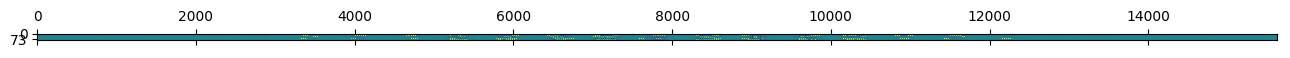

In [21]:
matshow(A)
yticks([0, length(cages)-1])
tight_layout()
savefig("data_matrix_viz.png", format="png", dpi=300, bbox_inches="tight")

How many columns are all zeros?

In [22]:
sum(sum(abs.(A), dims=1) .== 0.0)

10483

In [23]:
rank(A)

73

Lets see how far away the binding sites are away from the center of each cage:

In [24]:
function find_local_minima(energy_grid::Union{Grid{Float64}, Grid{Int}}; periodic_boundaries::Bool=true, tol::Float64=1e-6)
    # If we use periodic boundaries, we'll sample the edges of the grid
    if periodic_boundaries
        start = 1 
        ends = energy_grid.n_pts
    else
        start = 2 
        ends = energy_grid.n_pts .-1 
    end 
    local_minima = Array{Array{Float64}, 1}()

    for i = start:ends[1], j = start:ends[2], k = start:ends[3]
        flag = true
        if energy_grid.data[i,j,k] > 0 
            continue
        end
        for i_ = i-1:i+1, j_ = j-1:j+1, k_ = k-1:k+1
            if (i_, j_, k_) == (i, j, k)
                continue
            end
            idx = (i_, j_, k_) 
            idx = _pbc_boundaries(idx, energy_grid.n_pts)

            if energy_grid.data[idx...]  < energy_grid.data[i,j,k] + tol 
                flag = false
                break
            end
        end
        if flag
            coords = (energy_grid.origin .+ ([i, j, k] .* [energy_grid.box.a, energy_grid.box.b, energy_grid.box.c] ./ [energy_grid.n_pts...]))
            push!(local_minima, [coords..., energy_grid.data[i,j,k]])
        end
    end 
    return local_minima
end

find_local_minima (generic function with 1 method)

In [20]:
function _pbc_boundaries(idx::Tuple{Int, Int, Int}, n_pts::Tuple{Int, Int, Int})
    new_idx = [idx...]
    for xyz = 1:3
        if idx[xyz] < 1
            new_idx[xyz] = idx[xyz] + n_pts[xyz]
        end
        if idx[xyz] > n_pts[xyz]
            new_idx[xyz] = idx[xyz] - n_pts[xyz]
        end
    end
    return Tuple(new_idx)
end

_pbc_boundaries (generic function with 1 method)

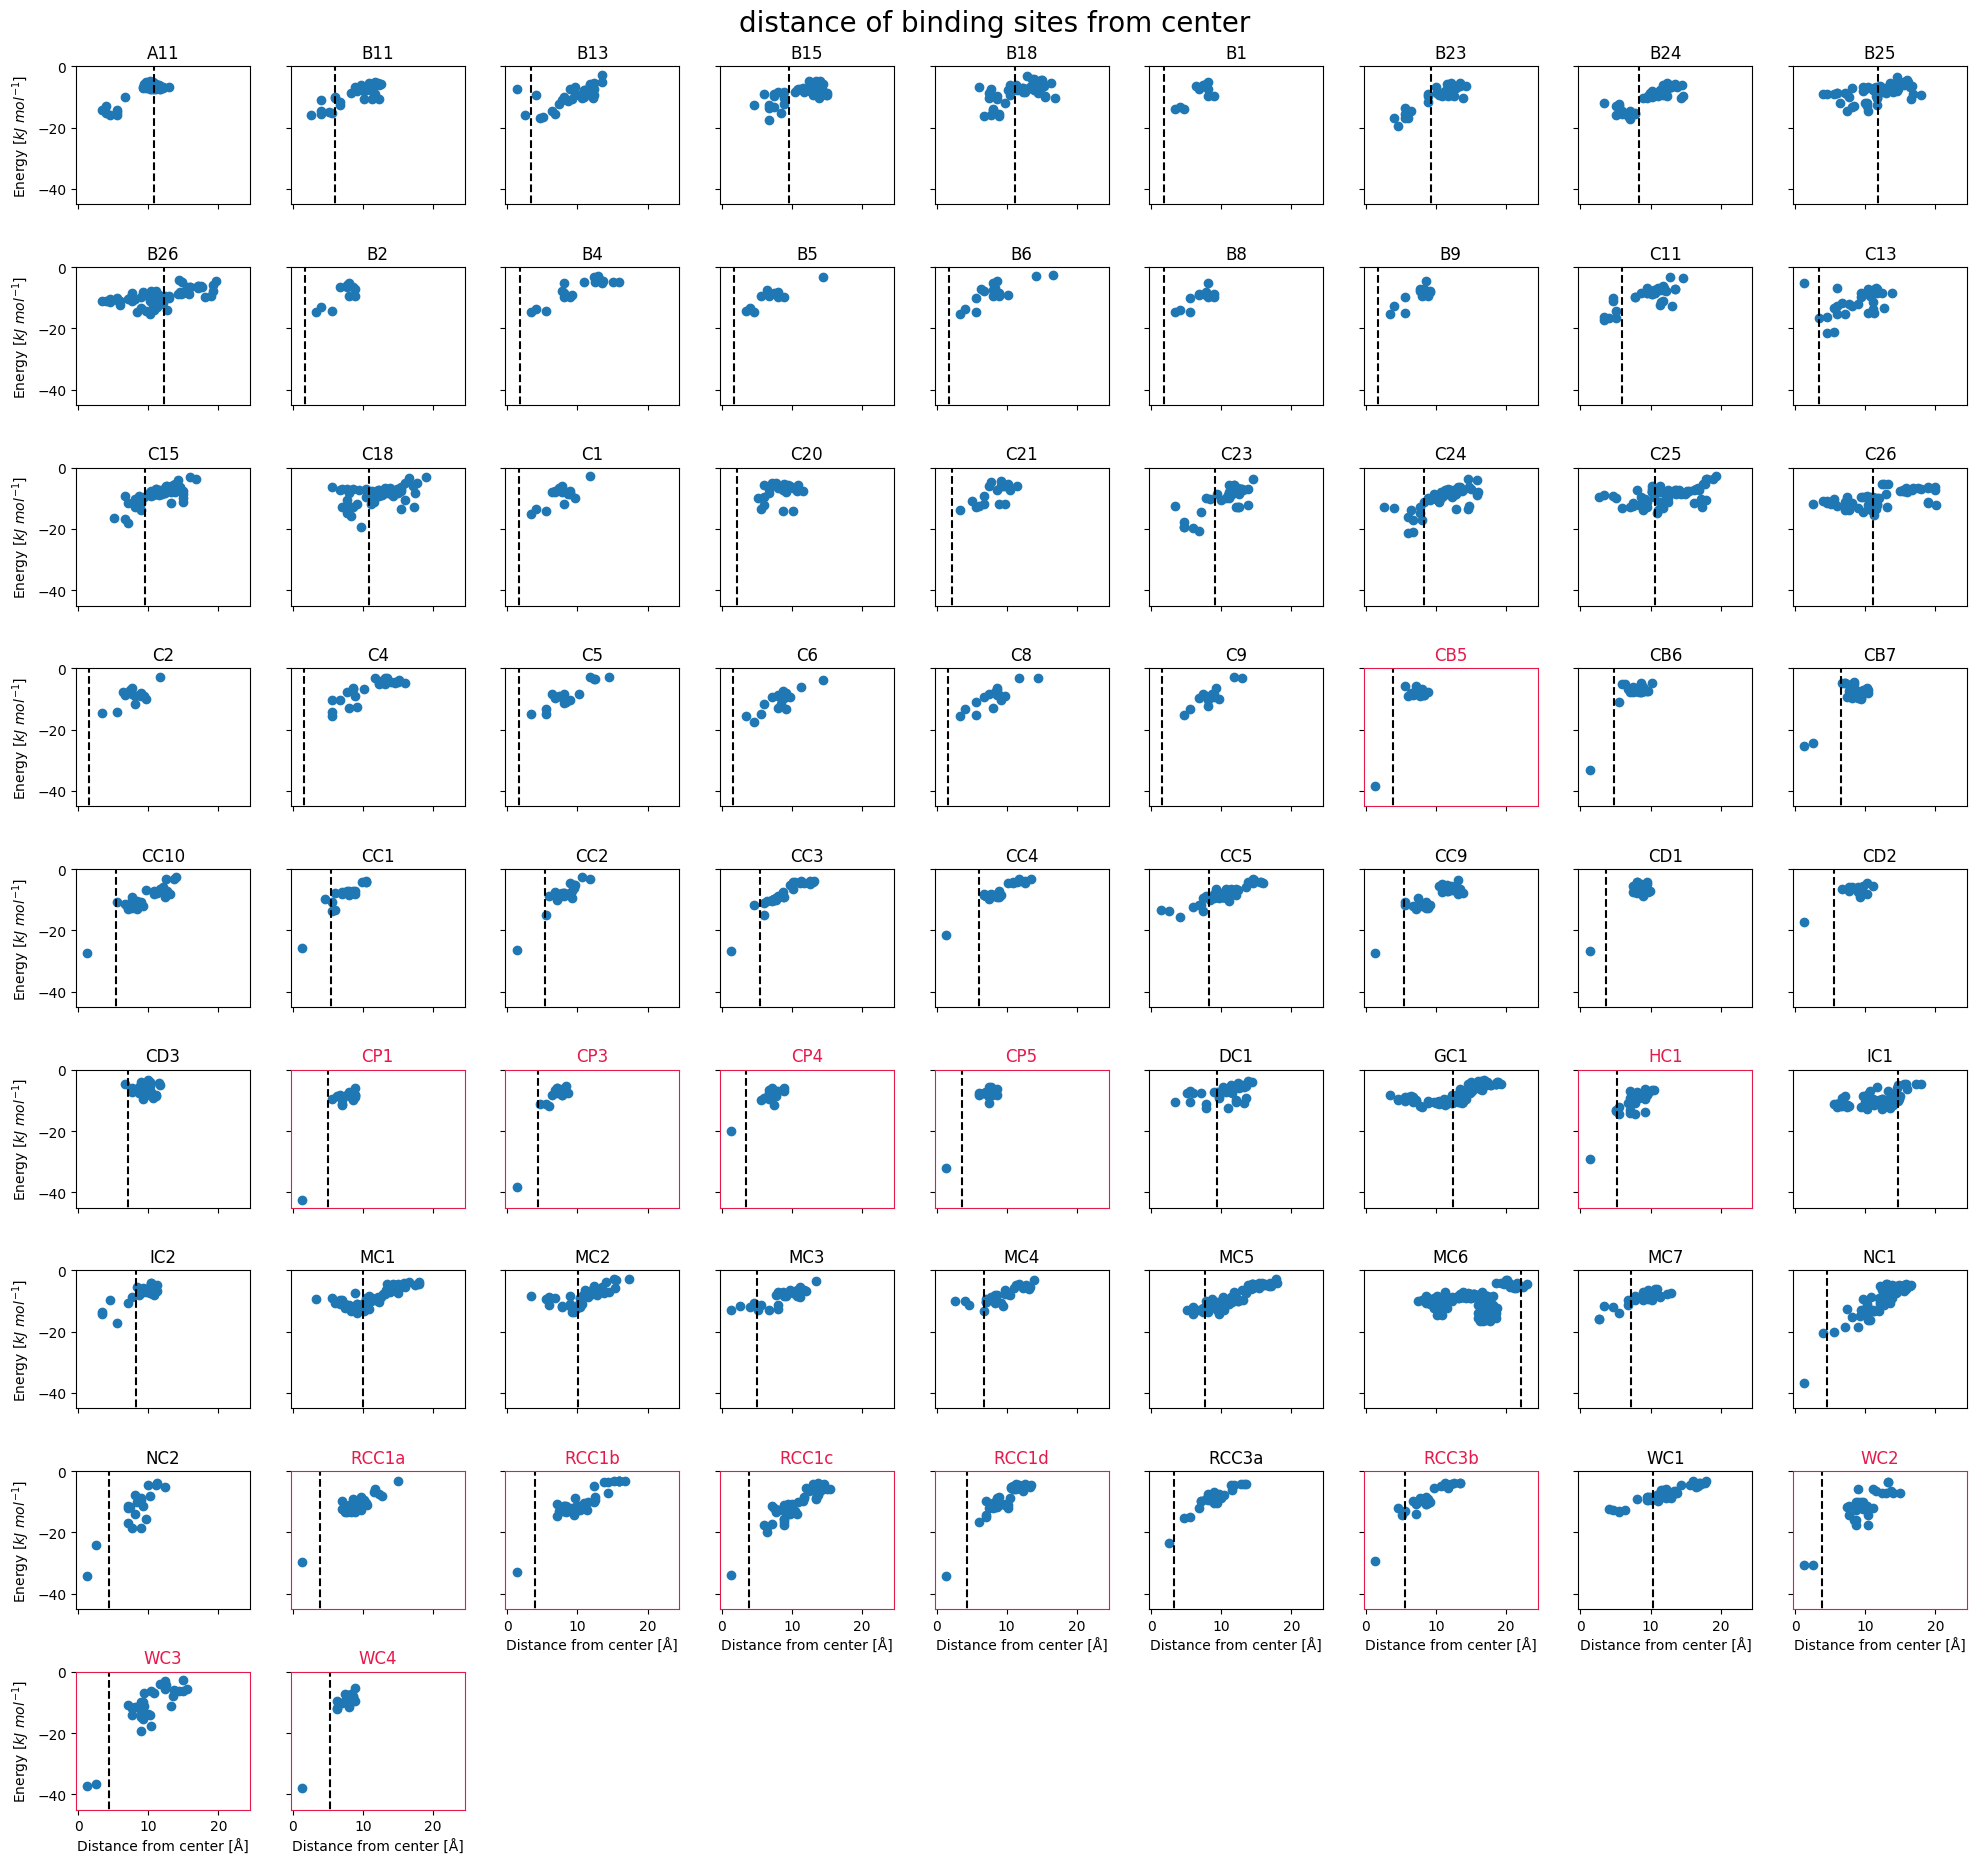

┌ Warning: indexing with colon as row will create a copy in the future use df[col_inds] to get the columns without copying
│   caller = top-level scope at In[61]:28
└ @ Core In[61]:28


In [61]:
inaccessible_cages = readdlm("inaccessible_cages.txt")
nrows = ceil(Int, sqrt(length(cages))) # in the big plot
fig, axs = plt.plt[:subplots](nrows=nrows, ncols=nrows, figsize=(20, 20),
                          sharex=true, sharey=true)
cage_no = 0
for i = 1:nrows
    for j = 1:nrows
        cage_no += 1
        
        # blank panel if no cage for the panel
        if cage_no > length(cages)
            axs[i, j][:axis]("off")
            continue
        end
        
        atoms, x = final_aligned_and_centered_cage(cages[cage_no])
        d = Inf
        a = :H
        vdw_radii = CSV.read("vdw_radii.csv")
        for k = 1:size(x)[2]
            dist = norm(x[:,k])
            if dist < d
                d = dist
                a = atoms[k]
            end
        end
        d *= 2.0
        atomidx = findfirst(string(a) .== vdw_radii[:,1])
        vdw_radius = vdw_radii[atomidx, 2]
        d = d - 2 * vdw_radius
        
        # rotate cage so its principal axes of inertia aligned with Cartesian axes.
        original_data = energies[cage_no]
        binding_sites = find_local_minima(original_data, periodic_boundaries=false, tol=10.0)
        distances = []
        energy = []
        for site in binding_sites
            push!(distances,norm(site[1:3]))
            push!(energy, site[4] * 8.314 / 1000)
        end
        
        axs[i, j][:scatter](distances, energy)
        axs[i, j][:set_title](cages[cage_no])
        axs[i, j][:plot]([d, d], [1, -46], "k--")
        if any(x -> x == cages[cage_no], inaccessible_cages)
            axs[i, j][:spines]["bottom"][:set_color]("#e6194B")
            axs[i, j][:spines]["top"][:set_color]("#e6194B")
            axs[i, j][:spines]["left"][:set_color]("#e6194B")
            axs[i, j][:spines]["right"][:set_color]("#e6194B")
            axs[i, j][:tick_params](axis='x', colors="#e6194B")
            axs[i, j][:tick_params](axis='y', colors="#e6194B")
            axs[i, j][:title][:set_color]("#e6194B")
        end
        if j == 1
            axs[i, j][:set_ylabel]("Energy \$[kJ \\ mol^{-1}]\$")
        end
        if cage_no > length(cages)-nrows
            axs[i, j][:xaxis][:set_tick_params](which="both", labelbottom=true)
            axs[i, j][:set_xlabel]("Distance from center [Å]")
        end
    end
end
st = plt.suptitle("distance of binding sites from center")
st[:set_y](0.96)
st[:set_size](20.0)

#plt.xticks([1, 2, 3], ["\$\\lambda_1\$", "\$\\lambda_2\$", "\$\\lambda_3\$"])
plt.ylim([-45, 0])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("distance_of_binding_sites.pdf", format="pdf")
plt.show()

Perform the SVD decomposition of the data matrix

In [114]:
UΣVᵀ = svd(A)

println("size of U: ", size(UΣVᵀ.U))
println("# singular values: ", length(UΣVᵀ.S))
println("size of Vᵀ: ", size(UΣVᵀ.Vt))

@assert(isapprox(A, UΣVᵀ.U * diagm(0 => UΣVᵀ.S) * UΣVᵀ.Vt))

size of U: (74, 74)
# singular values: 74
size of Vᵀ: (74, 15625)


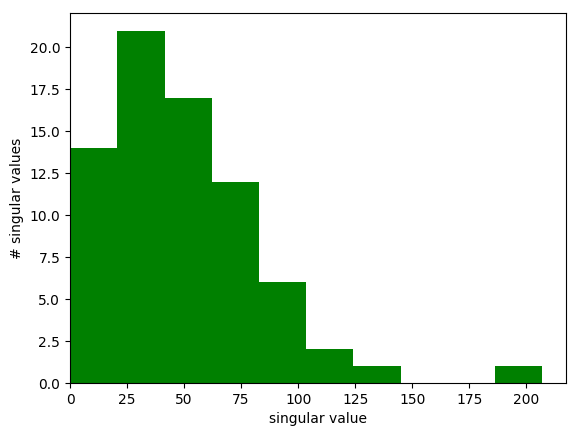

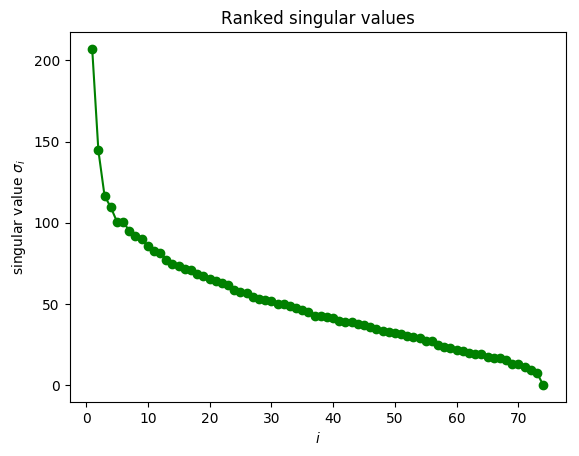

In [115]:
figure()
plt[:hist](UΣVᵀ.S, color="g")
xlabel("singular value")
ylabel("# singular values")
xlim(xmin=0)
savefig("distn_of_svs.png", format="png", dpi=300)

figure()
plot(1:length(UΣVᵀ.S), UΣVᵀ.S, color="g", marker="o")
xlabel("\$i\$")
ylabel("singular value \$\\sigma_i\$")
title("Ranked singular values")
savefig("svs_ordered.png", format="png", dpi=300)

ratio of norm of error to norm of $A$.
See pg. 19 of 
> A Singularly Valuable Decomposition: The SVD of a Matrix. Dan Kalman

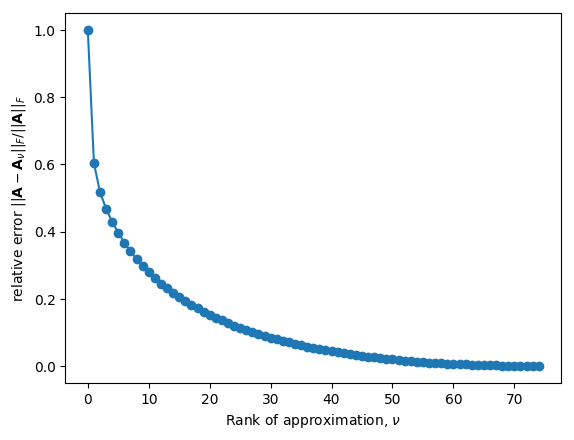

In [116]:
relative_err = 1.0 .- sqrt.([sum(UΣVᵀ.S[1:i] .^ 2) for i = 1:length(UΣVᵀ.S)] / sum(UΣVᵀ.S .^ 2))
relative_err = vcat([1.0], relative_err)

fig = figure()
xlabel("Rank of approximation, \$\\nu\$")
ylabel("relative error \$||\\mathbf{A}-\\mathbf{A}_\\nu||_F/||\\mathbf{A}||_F \$")
plot(0:length(UΣVᵀ.S), relative_err, marker="o")
savefig("relative_err_with_svs.png", format="png", dpi=300)

Take the latent space as a composition of the first `r` singular vectors.
Select `r` so that we recover a certain fraction of the energy, `fraction_energy_recovered`.

In [117]:
# assert singular values are sorted
@assert(sortperm(UΣVᵀ.S) == reverse([i for i = 1:length(UΣVᵀ.S)]))

desired_relative_err = 0.15
ν = findfirst(relative_err .< desired_relative_err) # number of singular values to include

@printf("%d singular values results in relative error %f; setting latent dim = %d.\n",
    ν, relative_err[ν], ν)

x_latent = UΣVᵀ.U[:, 1:ν] * diagm(0 => UΣVᵀ.S[1:ν])
@assert(isapprox(x_latent, A * UΣVᵀ.V[:, 1:ν]), "UΣ != AV")
@assert(size(x_latent) == (length(cages), ν))

22 singular values results in relative error 0.143795; setting latent dim = 22.


use t-SNE to embed latent representation in 2D

In [118]:
Random.seed!(1234)
x_tsne = tsne(x_latent, 2, 0, 100000, 5.0);
size(x_tsne)

Computing t-SNE  5%|██                                  |  ETA: 0:00:02
Computing t-SNE 10%|████                                |  ETA: 0:00:02
Computing t-SNE 15%|██████                              |  ETA: 0:00:02
Computing t-SNE 21%|████████                            |  ETA: 0:00:02
Computing t-SNE 25%|█████████                           |  ETA: 0:00:02
Computing t-SNE 30%|███████████                         |  ETA: 0:00:01
Computing t-SNE 35%|█████████████                       |  ETA: 0:00:01
Computing t-SNE 40%|██████████████                      |  ETA: 0:00:01
Computing t-SNE 45%|████████████████                    |  ETA: 0:00:01
Computing t-SNE 51%|██████████████████                  |  ETA: 0:00:01
Computing t-SNE 56%|████████████████████                |  ETA: 0:00:01
Computing t-SNE 61%|██████████████████████              |  ETA: 0:00:01
Computing t-SNE 65%|████████████████████████            |  ETA: 0:00:01
Computing t-SNE 70%|█████████████████████████           |  ETA: 

(74, 2)

write 2D t-SNE latent dim to file for D3 interactive viz

In [119]:
latent_dim_file = open("latent_dim.csv", "w")
@printf(latent_dim_file, "cage_image,x1,x2\n")
for (c, cage) in enumerate(cages)
    @printf(latent_dim_file, "%s_aligned.png,%f,%f\n", cage, x_tsne[c, :]...)
end
close(latent_dim_file)

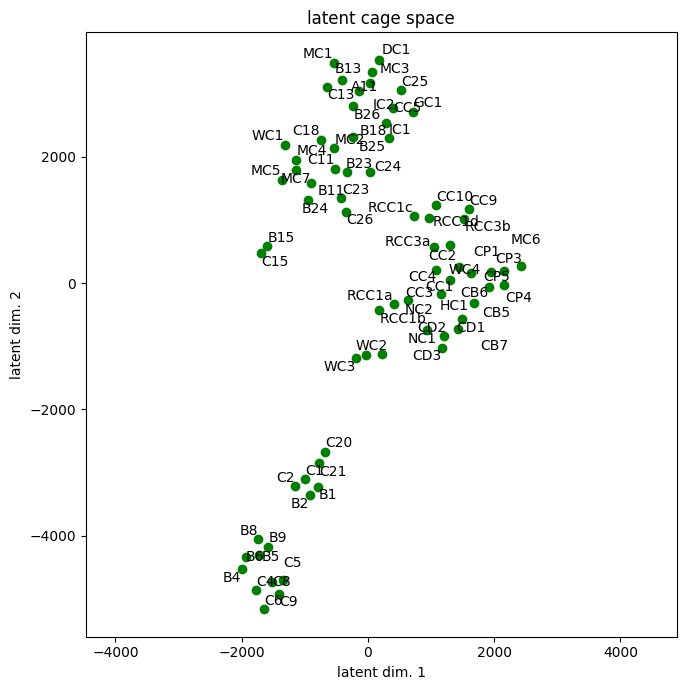

In [145]:
figure(figsize=(7, 7))
scatter(x_tsne[:, 1], x_tsne[:, 2], color="g")
# for i = 1:length(cages)
#     plt.annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
# end
texts = []
for i = 1:length(cages)
    push!(texts,
        annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
        )
end
adjustText.adjust_text(texts)
xlabel("latent dim. 1")
ylabel("latent dim. 2")
axis("equal")
title("latent cage space")
tight_layout()
savefig("latent_cage_space_2D.pdf", format="pdf", dpi=300)
show()

... t-SNE to embed in 3D

Computing t-SNE 42%|███████████████                     |  ETA: 0:00:00


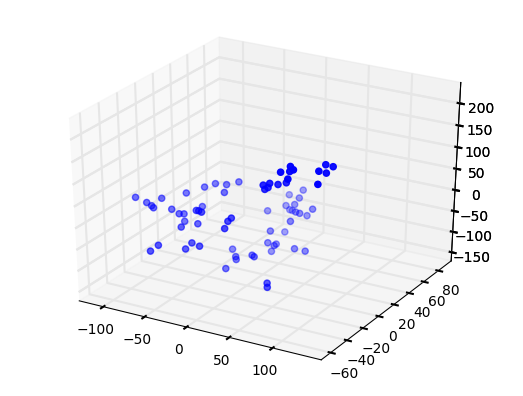

Computing t-SNE 89%|████████████████████████████████    |  ETA: 0:00:00
Computing t-SNE100%|████████████████████████████████████| Time: 0:00:00
  KL_divergence:  0.3757


In [121]:
x_tsne_3D = tsne(x_latent, 3, 0, 10000, 5.0);

plt.figure()
plt.scatter3D(x_tsne_3D[:, 1], x_tsne_3D[:, 2], x_tsne_3D[:, 3])
plt.show()

## Correlation between latent space and cage descriptors from `pywindow`

Crude cage size descriptors:

* `molecule_diameter`: if we could stuff the cage molecule into a sphere, how big would the sphere need to be?
* `void_diameter`: distance between center of mass of the molecule and the closest atom, corrected for appropriate vdW radii and multiplied by 2.

See:

> M. Miklitz, S. Jiang, R. Clowes, M. E. Briggs, A. I. Cooper and K. E. Jelfs, Computational Screening of Porous Organic Molecules for Xenon/Krypton Separation, J. Phys. Chem. C, 2017, 121, 15211–15222.

We computed these from `pywindow`:

> M. Miklitz, K. E. Jelfs. pywindow: Automated Structural Analysis of Molecular Pores. ChemRxiv.

(checked WC3 in Table 1 for correspondence of those we computed.) See `cage_descriptors.ipynb`.

In [122]:
df_descriptors = CSV.read("pywindow_cage_descriptors.csv")
head(df_descriptors)

,cage,molecule_diameter_A,pore_diameter_A,nb_windows
,String⍰,Float64⍰,Float64⍰,Int64⍰
1,A11,20.2317,10.7758,4
2,B11,20.9082,6.23614,4
3,B13,24.7109,3.41116,4
4,B15,25.3523,9.82186,4
5,B18,28.0574,11.4157,4
6,B1,15.1623,2.06207,3


Put in an array with same order as `cages` for easy plotting

In [123]:
pore_diameters = zeros(length(cages))
molecule_diameters = zeros(length(cages))
nb_windows = zeros(Int, length(cages))
for (i, cage) in enumerate(cages)
    idx_this_cage = df_descriptors[:cage] .== cage
    @assert(sum(idx_this_cage) == 1, @sprintf("%s not found in df_descriptors (or multiple)!", cage))
    pore_diameters[i] = df_descriptors[idx_this_cage, :pore_diameter_A][1]
    molecule_diameters[i] = df_descriptors[idx_this_cage, :molecule_diameter_A][1]
    nb_windows[i] = df_descriptors[idx_this_cage, :nb_windows][1]
end

Visualize distribution of descriptors among the cages.

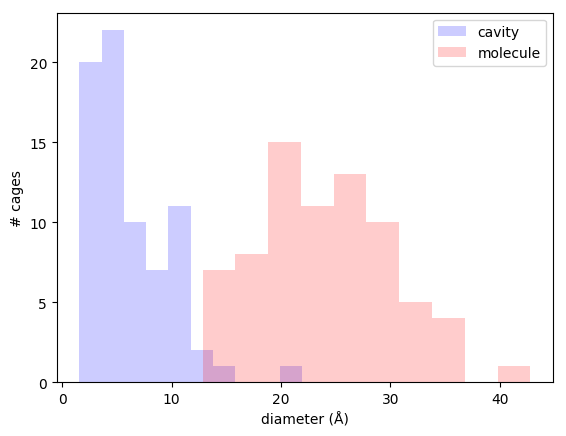

In [143]:
plt.figure()
plt.plt[:hist](pore_diameters, color="b", alpha=0.2, label="cavity")
plt.plt[:hist](molecule_diameters, color="r", alpha=0.2, label="molecule")
plt.legend()
plt.xlabel("diameter (Å)")
plt.ylabel("# cages")
plt.savefig("pywindow_descriptors_distn.png", format="png", dpi=300)

Visualize distribution of the number of windows

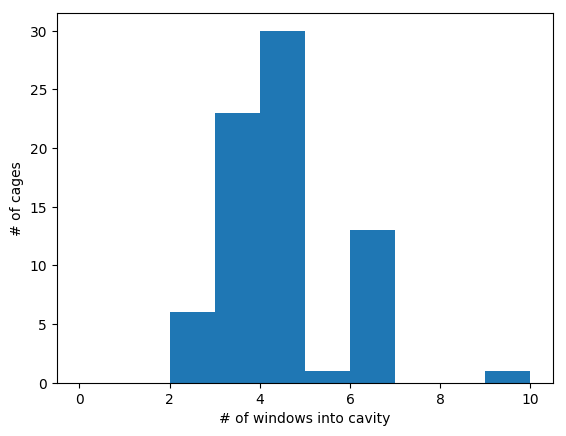

PyObject Text(24,0.5,'# of cages')

In [125]:
fig = plt.figure()
plt.plt[:hist](nb_windows, bins=0:10)
plt.xlabel("# of windows into cavity")
plt.ylabel("# of cages")

Assess if clustering picks on up the descriptors.
Color according to pore diameters, make size according to molecule diameter.
the marker size is the area, so we should make the size on the order of `molecule_diameter^2`.

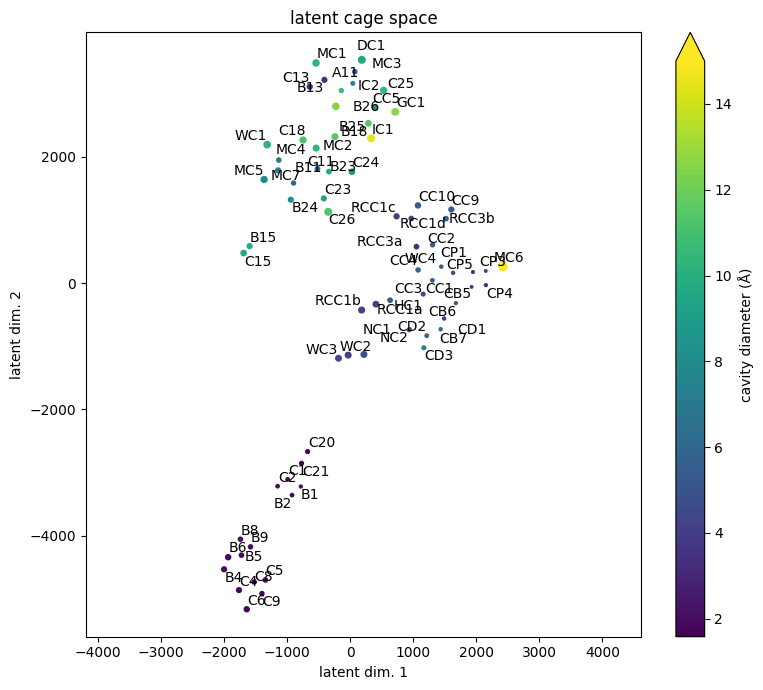

In [150]:
plt.figure(figsize=(8, 7))
plt.scatter(x_tsne[:, 1], x_tsne[:, 2],
    c=pore_diameters,
    s=molecule_diameters .^ 2 / maximum(molecule_diameters .^ 2) * 35.0,
    vmax=15.0
)
texts = []
for i = 1:length(cages)
    push!(texts,
        plt.annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
        )
end
adjustText.adjust_text(texts)
# for i = 1:length(cages)
#     plt.annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
# end
cbar = plt.colorbar(extend="max", label="cavity diameter (Å)")
plt.title("latent cage space")
plt.xlabel("latent dim. 1")
plt.ylabel("latent dim. 2")
plt.axis("equal")
plt.tight_layout()
plt.savefig("cage_space_colored_by_diams_2D.png", format="png", dpi=300)
plt.show()

hypothesis that first eigencage picks up the pore size.

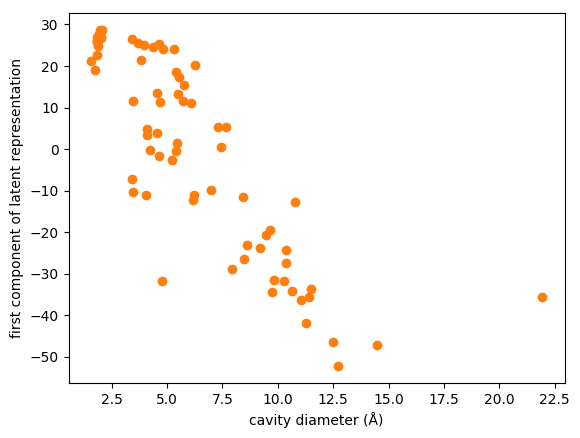

In [147]:
fig = plt.figure()
plt.scatter(pore_diameters, UΣVᵀ.U[:, 1] * UΣVᵀ.S[1], color="C1")
plt.xlabel("cavity diameter (Å)")
plt.ylabel("first component of latent representation")
plt.savefig("first_component_captures_pore_diameter.pdf", format="pdf")

Assess if clustering picks up on # windows 

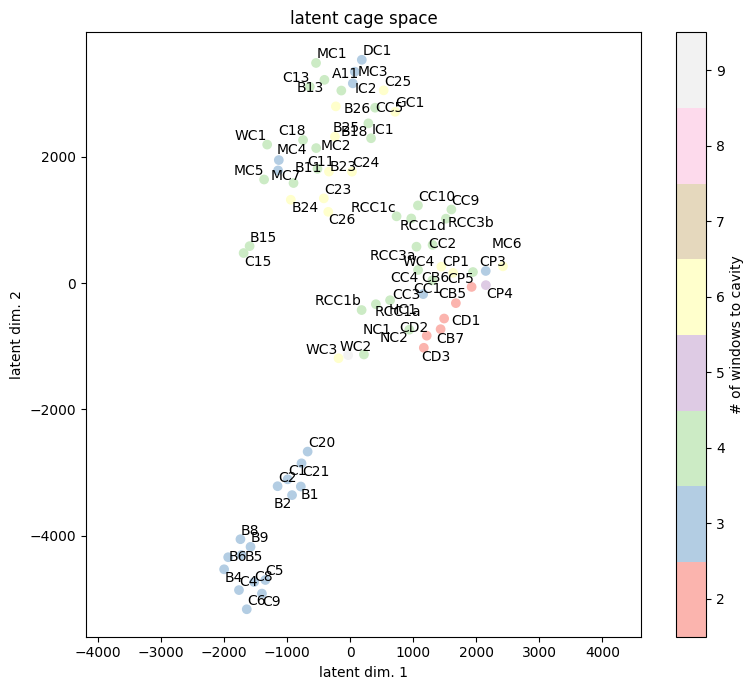

In [148]:
cmap = plt.get_cmap("Pastel1", maximum(nb_windows) - minimum(nb_windows)+1)

plt.figure(figsize=(8, 7))
plt.scatter(x_tsne[:, 1], x_tsne[:, 2],
    c=nb_windows, cmap=cmap, vmin=minimum(nb_windows)-0.5, vmax=maximum(nb_windows)+0.5
)
texts = []
for i = 1:length(cages)
    push!(texts,
        plt.annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
        )
end
adjustText.adjust_text(texts)
# for i = 1:length(cages)
#     plt.annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
# end
#cbar = plt.colorbar(extend="max", label="cavity diameter (Å)")
plt.title("latent cage space")
plt.xlabel("latent dim. 1")
plt.ylabel("latent dim. 2")
plt.axis("equal")
plt.colorbar(label="# of windows to cavity")
plt.tight_layout()
plt.savefig("cage_space_colored_by_nb_windows.png", format="png", dpi=300)
plt.show()

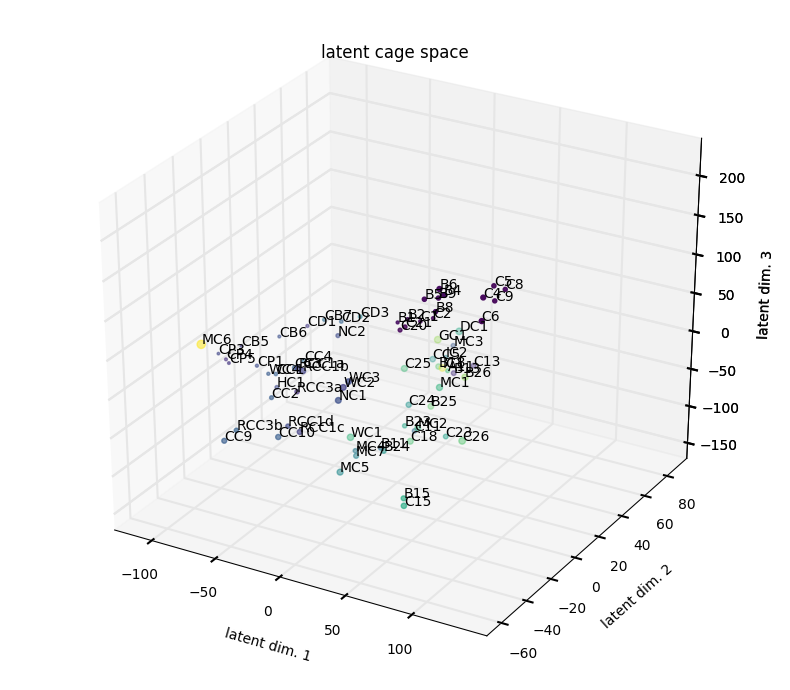

In [149]:
fig = plt.figure(figsize=(8, 7))
ax = fig[:add_subplot](111, projection="3d")

ax[:scatter](x_tsne_3D[:, 1], x_tsne_3D[:, 2], x_tsne_3D[:, 3],
    c=pore_diameters,
    s=molecule_diameters .^ 2 / maximum(molecule_diameters .^ 2) * 35.0,
    vmax=15.0)
for i = 1:length(cages)
    ax[:text](x_tsne_3D[i, 1], x_tsne_3D[i, 2], x_tsne_3D[i, 3], cages[i])
end
plt.xlabel("latent dim. 1")
plt.ylabel("latent dim. 2")
plt.zlabel("latent dim. 3")
plt.title("latent cage space")
plt.tight_layout()
plt.savefig("cage_space_colored_by_diams_3D.png", format="png", dpi=300)
plt.show()

### Visualize the eigen-cages
i.e. discovered concepts, which are the rows of $\mathbf{V}^T$.

In [130]:
for concept_id = 1:ν
    x_concept = transpose(UΣVᵀ.V)[concept_id, :] # flattened
    x_concept = reshape(x_concept, (nb_grid_pts, nb_grid_pts, nb_grid_pts))

    grid = Grid(snapshot_box, (nb_grid_pts, nb_grid_pts, nb_grid_pts), 
                reshape(x_concept, (nb_grid_pts, nb_grid_pts, nb_grid_pts)), 
                :accessibility, -center_of_box)

    write_cube(grid, @sprintf("eigencage%d.cube", concept_id))
end

	See /home/sturlusa/my_projects/latent_cage_space/data/grids/eigencage1.cube
	See /home/sturlusa/my_projects/latent_cage_space/data/grids/eigencage2.cube
	See /home/sturlusa/my_projects/latent_cage_space/data/grids/eigencage3.cube
	See /home/sturlusa/my_projects/latent_cage_space/data/grids/eigencage4.cube
	See /home/sturlusa/my_projects/latent_cage_space/data/grids/eigencage5.cube
	See /home/sturlusa/my_projects/latent_cage_space/data/grids/eigencage6.cube
	See /home/sturlusa/my_projects/latent_cage_space/data/grids/eigencage7.cube
	See /home/sturlusa/my_projects/latent_cage_space/data/grids/eigencage8.cube
	See /home/sturlusa/my_projects/latent_cage_space/data/grids/eigencage9.cube
	See /home/sturlusa/my_projects/latent_cage_space/data/grids/eigencage10.cube
	See /home/sturlusa/my_projects/latent_cage_space/data/grids/eigencage11.cube
	See /home/sturlusa/my_projects/latent_cage_space/data/grids/eigencage12.cube
	See /home/sturlusa/my_projects/latent_cage_space/data/grids/eigencage13.

### reconstruct a material as singular values are added

In [131]:
which_cage = "B25"
cage_id = findfirst(cages .== which_cage)

for sv = 1:14
    # approximate matrix
    A_ν = UΣVᵀ.U[:, 1:sv] * diagm(0 => UΣVᵀ.S[1:sv]) * transpose(UΣVᵀ.V[:, 1:sv])
    # reconstruction
    x = A_ν[cage_id, :] .+ average_cage
    
    grid = Grid(snapshot_box, (nb_grid_pts, nb_grid_pts, nb_grid_pts), 
            reshape(x, (nb_grid_pts, nb_grid_pts, nb_grid_pts)), 
            :accessibility, -center_of_box)

    write_cube(grid, @sprintf("%s_reconstructed_%dsvs.cube", which_cage, sv))
end

	See /home/sturlusa/my_projects/latent_cage_space/data/grids/B25_reconstructed_1svs.cube
	See /home/sturlusa/my_projects/latent_cage_space/data/grids/B25_reconstructed_2svs.cube
	See /home/sturlusa/my_projects/latent_cage_space/data/grids/B25_reconstructed_3svs.cube
	See /home/sturlusa/my_projects/latent_cage_space/data/grids/B25_reconstructed_4svs.cube
	See /home/sturlusa/my_projects/latent_cage_space/data/grids/B25_reconstructed_5svs.cube
	See /home/sturlusa/my_projects/latent_cage_space/data/grids/B25_reconstructed_6svs.cube
	See /home/sturlusa/my_projects/latent_cage_space/data/grids/B25_reconstructed_7svs.cube
	See /home/sturlusa/my_projects/latent_cage_space/data/grids/B25_reconstructed_8svs.cube
	See /home/sturlusa/my_projects/latent_cage_space/data/grids/B25_reconstructed_9svs.cube
	See /home/sturlusa/my_projects/latent_cage_space/data/grids/B25_reconstructed_10svs.cube
	See /home/sturlusa/my_projects/latent_cage_space/data/grids/B25_reconstructed_11svs.cube
	See /home/sturlusa

### Compare latent space with Henry coefficients
From Melanie: UFF, 14 A cutoff, geometric mixing rules, 298.0 K

In [132]:
dfs = Dict{String, DataFrame}()
for gas in ["He", "Kr", "Xe"]
    dfs[gas] = CSV.read("henry_coefs/" * gas * "_cage_KH.csv")
end
dfs["He"]

,cage,KH_mol/(m³-bar),KH_mmol/(g-bar),KH_mmol/(kg-Pa),err_KH_mmol/(g-bar),Qst_kJ/mol,elapsed time (min)
,String⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,A11_aligned.cif,40.289,1.86594,1.86594e-5,4.89849e-5,2.54583,24.8768
2,B11_aligned.cif,40.2448,1.68872,1.68872e-5,0.000113633,2.55087,51.1547
3,B13_aligned.cif,40.1685,1.45798,1.45798e-5,4.91375e-5,2.55826,67.2865
4,B15_aligned.cif,40.274,1.90037,1.90037e-5,8.76876e-5,2.54314,106.211
5,B18_aligned.cif,40.2729,1.7852,1.7852e-5,2.49113e-5,2.54782,104.807
6,B1_aligned.cif,40.2332,2.56431,2.56431e-5,0.000107504,2.52134,12.2629
7,B23_aligned.cif,40.2413,1.50651,1.50651e-5,3.43654e-5,2.55883,40.3236
8,B24_aligned.cif,40.2658,1.48899,1.48899e-5,7.05684e-5,2.56217,56.9147
9,B25_aligned.cif,40.2713,1.72822,1.72822e-5,2.29469e-5,2.54952,67.7069


In [133]:
df_new = DataFrame(cage=String[], KH_Xe=Float64[], KH_Kr=Float64[])
for row in eachrow(dfs["Xe"])
    kh_he = dfs["He"][dfs["He"][:cage] .== row[:cage], 
        Symbol("KH_mol/(m³-bar)")][1]
    kh_kr = dfs["Kr"][dfs["Kr"][:cage] .== row[:cage], 
        Symbol("KH_mol/(m³-bar)")][1]
    push!(df_new, [row[:cage], row[Symbol("KH_mol/(m³-bar)")] - kh_he, kh_kr - kh_he])
end
df_new[:Xe_Kr_selectivity] = df_new[:KH_Xe] ./ df_new[:KH_Kr]
head(df_new)

,cage,KH_Xe,KH_Kr,Xe_Kr_selectivity
,String,Float64,Float64,Float64
1,A11_aligned.cif,22.36,8.23432,2.71546
2,B11_aligned.cif,25.9486,9.26889,2.79953
3,B13_aligned.cif,31.2259,10.4816,2.97912
4,B15_aligned.cif,18.3896,7.31678,2.51334
5,B18_aligned.cif,17.795,7.29464,2.43946
6,B1_aligned.cif,11.2393,4.50156,2.49677


In [134]:
S_Xe_kr = [df_new[df_new[:cage] .== cage * "_aligned.cif", 
        :Xe_Kr_selectivity][1] for cage in cages][:]

74-element Array{Float64,1}:
  2.7154568539897412
  2.7995337803722045
  2.9791219953211616
  2.513344604257898 
  2.439458412871356 
  2.4967652715248176
  3.5766384932529087
  3.1119506536266366
  2.2863902208987827
  2.4698590751060863
  2.553681089904987 
  2.4814698047387265
  2.5829960732811226
  ⋮                 
 18.591580670038077 
 15.423766898019501 
  2.478360925952521 
  3.05859620212241  
  5.178701517299147 
  7.279271411447992 
  6.557558869300938 
 12.972085114857036 
  2.3915163369019736
 12.76763310069456  
 20.391775643643673 
 30.759371693662313 

21.27475365951604


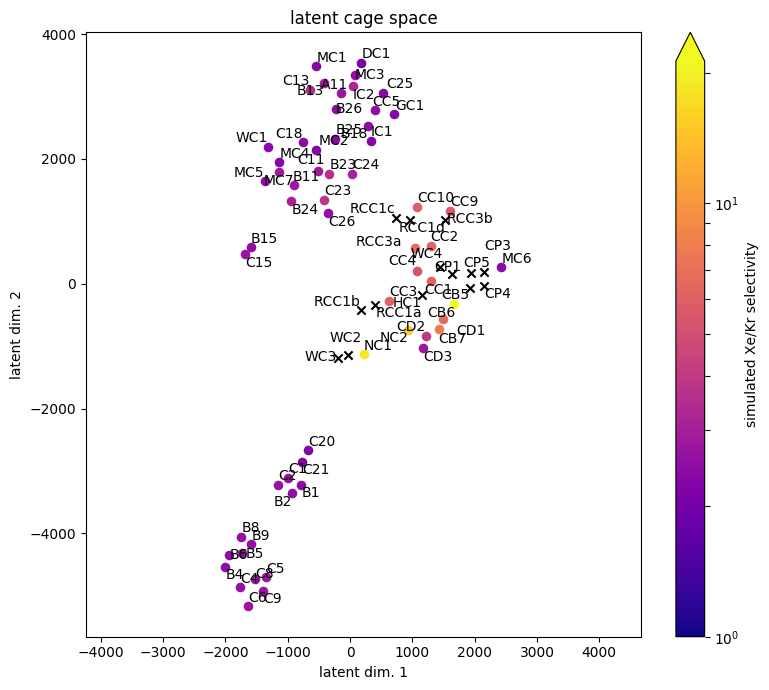

got here


In [142]:
plt.figure(figsize=(8, 7))
#plt.scatter(x_tsne[:, 1], x_tsne[:, 2],
#    s=35,
#    c=S_Xe_kr,
#    norm=PyPlot.matplotlib[:colors][:LogNorm](),
#    cmap="plasma"
#)
maxi = 0
for (i, cage) in enumerate(cages)
    if any(x -> x == cage, inaccessible_cages)
        continue
    else
        if S_Xe_kr[i] > maxi
            maxi = S_Xe_kr[i]
        end
    end
end
println(maxi)
cnorm = PyPlot.matplotlib[:colors][:LogNorm](vmin=1.0, vmax=maxi)
m = plt.plt[:cm][:ScalarMappable](norm=cnorm, cmap=plt.plt[:cm][:plasma])
m[:set_array]([]) # trick


inaccessible_cages = readdlm("inaccessible_cages.txt")

texts = []
for (i, cage) = enumerate(cages)
    if any(x -> x == cage, inaccessible_cages)
        plt.scatter(x_tsne[i, 1], x_tsne[i, 2],
                    s=35,
                    #c=m[:to_rgba](S_Xe_kr[i]),
                    c="k",
                    marker = "x"
                    )
    else
        plt.scatter(x_tsne[i, 1], x_tsne[i, 2],
                    s=35,
                    c=m[:to_rgba](S_Xe_kr[i]),
                    marker = "o"
                    )
    end
    push!(texts,
        plt.annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
        )
end
    println("got here")

adjustText.adjust_text(texts)
# for i = 1:length(cages)
#     plt.annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
# end
cbar = plt.colorbar(m, extend="max", label="simulated Xe/Kr selectivity")
plt.title("latent cage space")
plt.xlabel("latent dim. 1")
plt.ylabel("latent dim. 2")
plt.axis("equal")
plt.tight_layout()
plt.savefig("cage_space_colored_by_S_Xe_Kr.png", format="png", dpi=300)
plt.show()

Compare Henry coefficients to experimental data for noria and CC3

Noria data from: 10.1002/chem.201602131
CC3 data from: Fig 2c of DOI 10.1038/nmat4035 (plot digitized, sorry for noise; it is on a log scale)

In [136]:
df_expt = Dict("noria" => Dict("Xe" => CSV.read("noria/Xe_expt_298K.csv"),
                               "Kr" => CSV.read("noria/Kr_expt_298K.csv")
                               ),
               "CC3"   => Dict("Xe" => CSV.read("cc3/Xe_expt_298K.csv"),
                               "Kr" => CSV.read("cc3/Kr_expt_298K.csv")
                               )
               )

Dict{String,Dict{String,DataFrame}} with 2 entries:
  "CC3"   => Dict("Kr"=>20×2 DataFrame…
  "noria" => Dict("Kr"=>22×2 DataFrame…

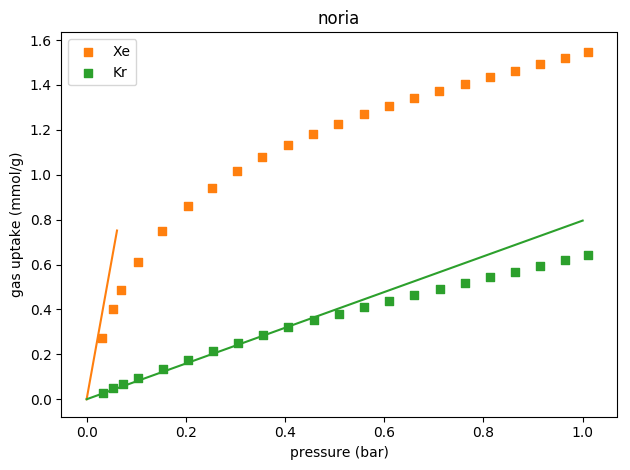

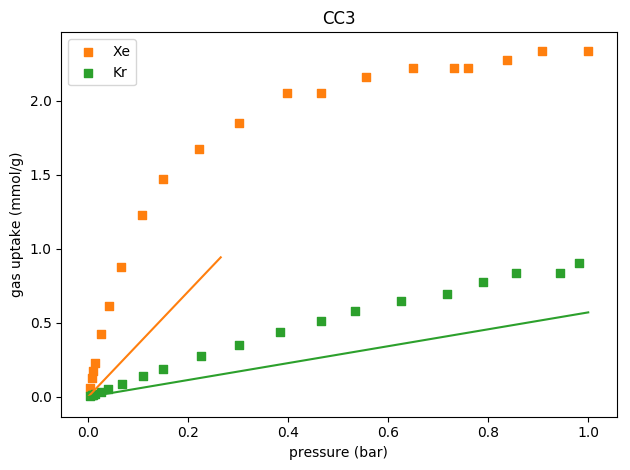

In [146]:
gas_colorz = Dict("Xe" => "C1", "Kr" => "C2")
markerz = Dict("Xe" => "s", "Kr" => "s")
xtal_name = Dict("noria" => "NC2_aligned.cif", "CC3" => "CC3_aligned.cif")

for cage in ["noria", "CC3"]
    fig = plt.figure()
    plt.xlabel("pressure (bar)")
    plt.ylabel("gas uptake (mmol/g)")
    
    P = collect(range(0, stop=1, length=50))
    KH_He =  dfs["He"][dfs["He"][:cage] .== xtal_name[cage], Symbol("KH_mmol/(g-bar)")][1]
    for gas in ["Xe", "Kr"]
        # plot experimental data
        if cage == "noria"
            df_expt[cage][gas][Symbol("P(bar)")] = df_expt[cage][gas][Symbol("P(torr)")] * 0.00133322
        end
        plt.scatter(df_expt[cage][gas][Symbol("P(bar)")], 
                    df_expt[cage][gas][Symbol("L(mmol/g)")], label=gas,
                    color=gas_colorz[gas], marker=markerz[gas])
        
        # grab simulated henry coeff and plot resulting henry's law
        KH =  dfs[gas][dfs[gas][:cage] .== xtal_name[cage], Symbol("KH_mmol/(g-bar)")][1]
        nH = (KH - KH_He) * P
        idx_keep = nH .< 1.0
        plt.plot(P[idx_keep], nH[idx_keep], color=gas_colorz[gas])
    end
    plt.title(cage)
    plt.legend()
    plt.tight_layout()
    plt.savefig(cage * "_expt_sim_comparison.png", format="png")
end

## A walk through latent space

In [138]:
cage_i = "DC1"
cage_j = "CC9"

idx_i = findfirst(cages[:] .== cage_i)
idx_j = findfirst(cages[:] .== cage_j)

x_latent_i = (UΣVᵀ.U[:, 1:ν] * diagm(0 => UΣVᵀ.S[1:ν]))[idx_i, :]
x_latent_j = (UΣVᵀ.U[:, 1:ν] * diagm(0 => UΣVᵀ.S[1:ν]))[idx_j, :]
# c is interpreting parameter
for c in 0.0:0.2:1.0
    x_latent_fictitious = c * x_latent_i + (1 - c) * x_latent_j
    x_fictitious = x_latent_fictitious' * UΣVᵀ.V[:, 1:ν]'
    x_fictitious = x_fictitious' # back to column vector
    # add average cage
    x_fictitious = x_fictitious + average_cage
    grid = Grid(snapshot_box, (nb_grid_pts, nb_grid_pts, nb_grid_pts), 
               reshape(x_fictitious, (nb_grid_pts, nb_grid_pts, nb_grid_pts)),
               :accessibility, -center_of_box)
    write_cube(grid, @sprintf("%s_%s_interpolation_c_%.2f.cube", cage_i, cage_j, c))
end

	See /home/sturlusa/my_projects/latent_cage_space/data/grids/DC1_CC9_interpolation_c_0.00.cube
	See /home/sturlusa/my_projects/latent_cage_space/data/grids/DC1_CC9_interpolation_c_0.20.cube
	See /home/sturlusa/my_projects/latent_cage_space/data/grids/DC1_CC9_interpolation_c_0.40.cube
	See /home/sturlusa/my_projects/latent_cage_space/data/grids/DC1_CC9_interpolation_c_0.60.cube
	See /home/sturlusa/my_projects/latent_cage_space/data/grids/DC1_CC9_interpolation_c_0.80.cube
	See /home/sturlusa/my_projects/latent_cage_space/data/grids/DC1_CC9_interpolation_c_1.00.cube


## Radar plots 
(cool was to visualize a high-dimensional representation but not used in the paper)

In [139]:
function draw_radar_plot(x::Array{Float64, 1})
    n_dims = length(x)
    angles = range(0, stop = 2 * π, length = n_dims + 1)[1:end-1]
    # make periodic
    x = vcat(x, [x[1]])
    angles = vcat(angles, [angles[1]])
    labels = ["c$i" for i = 1:n_dims]
    
    fig = figure()
    ax = fig[:add_subplot](111, polar=true)
    ax[:grid](true)
    ax[:set_thetagrids](angles * 180.0 / π, labels)  # Set the label for each axis
    ax[:plot](angles, x, "-o", linewidth=2)  # Draw the plot (or the frame on the radar chart)
    ax[:fill](angles, x, alpha=0.25)  #Fulfill the area
end

function draw_radar_plot(x::Array{Float64, 2})
    n_dims = size(x)[2]
    angles = range(0, stop = 2 * π, length = n_dims + 1)[1:end-1]
    # make periodic
    angles = vcat(angles, [angles[1]])
    labels = ["c$i" for i = 1:n_dims]
    
    fig = figure()
    ax = fig[:add_subplot](111, polar=true)
    ax[:grid](true)
    ax[:set_thetagrids](angles * 180.0 / π, labels)  # Set the label for each axis
    for i = 1:size(x)[1]
        x_viz = vcat(x[i, :], [x[i, 1]])
        ax[:plot](angles, x_viz, "-o", linewidth=0.5)  # Draw the plot (or the frame on the radar chart)
        # ax[:fill](angles, x_viz, alpha=0.25)  #Fulfill the area
    end
    @warn "think this might beed to be transpose"
end

draw_radar_plot(x_latent[1, 1:5])
draw_radar_plot(x_latent[1, :])
draw_radar_plot(x_latent)
#ax.set_rlim(0,250)

UndefVarError: UndefVarError: figure not defined